# Notebook for analyzing expression of diagnostic genes in rnaSeq tpm data for 5GB1 bacteria 

Collaborators: 
* Vrishabhadev Sathish Kumar
* PI: Erin Wilson

Data files:
* RNA-seq output from barrelseq pipeline
* mapping from sample id to experiment condition
* diagnostic genes identified by Dr. Lidstrom

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import copy as cp
import math

In [4]:
# load TPM data
tpm_data_file = 'data/TPM_counts.tsv'
sample2condition_file = 'data/sample2condition.txt'
diagnostic_genes_file = 'data/diagnostic_genes.csv'
unstable_diag_genes_file = 'data/unstable_diagnostic_expression.csv'

# load TPM data
df = pd.read_csv(tpm_data_file,sep='\t').fillna('')

# Parse and obtain usable dataframe of raw tpm
df_raw_tpm = df.iloc[:, 10:].T
loci = df["locus_tag"]
df_raw_tpm = df_raw_tpm.set_axis(loci, axis = 1)

    
# load mapping from sample to condition
with open(sample2condition_file,'r') as f:
    sample2condition = dict(x.strip().split() for x in f.readlines())

    
# load the diagnostic genes data
df_diagnostics = pd.read_csv(diagnostic_genes_file)

# load the unstable diagnostic genes data
df_unstable_diag_samples = pd.read_csv(unstable_diag_genes_file)

In [5]:
df_raw_tpm

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,2.933003,1.607784,1.415515,3.200081,1.522728,2.013385,8.890269,1.632474,0.790911,0.446398,...,170.826337,0.973237,2.344352,2.331287,4.867523,2.300157,5.261582,9.389775,21.657488,27.832080
5GB1_ferm_WT_QC_tpm,6.033848,3.895284,2.549771,4.301580,3.797084,1.694449,9.506517,3.340407,2.160868,1.134421,...,259.349616,2.866741,1.856930,0.951269,3.972334,3.217944,12.526353,21.072962,42.254357,41.530602
5GB1_FM03_TR1_QC_tpm,48.864921,51.315629,33.906257,64.584281,74.801354,13.090237,50.320911,20.811187,21.910217,18.096708,...,6655.778183,56.948463,52.002311,60.628466,23.015801,104.488835,379.686212,500.129230,1191.565348,796.964423
5GB1_FM03_TR2_QC_tpm,52.197450,54.947425,29.979783,72.717824,62.709260,24.874673,71.255094,19.773190,19.421485,16.776993,...,6480.237054,50.243190,41.376658,66.581832,54.669612,103.864151,401.742811,495.262554,1232.784967,724.291958
5GB1_FM11_TR1_QC_tpm,25.751902,37.216017,21.716802,53.032824,46.348014,42.426259,58.772307,9.667881,8.212313,12.634273,...,6651.883413,25.635202,29.059082,59.545627,34.189659,78.264069,208.094267,260.011454,666.589153,461.697526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1C-5G-N-BR2_tpm,33.432274,48.142385,22.006566,64.648318,39.358066,34.654512,107.541275,33.869275,23.770815,20.064562,...,9003.930101,20.600870,37.114422,39.499880,42.467068,30.766617,166.101675,59.523445,259.828426,404.714461
5GB1C-JG15-La-BR1_tpm,39.880174,45.465136,22.658157,69.119079,38.992158,67.033753,130.729298,39.968258,22.454067,18.039069,...,3318.767885,10.724405,39.422680,49.109710,46.810258,22.101468,96.169044,47.641158,134.795621,265.487592
5GB1C-JG15-La-BR2_tpm,38.355431,46.498139,22.753325,65.643179,35.870964,51.959561,120.575354,37.092594,20.769383,17.655632,...,3458.558649,15.496249,41.910716,53.086286,44.827579,19.753259,93.527806,60.667488,160.260255,308.428817
5GB1C-JG15-N-BR1_tpm,30.247582,37.152951,19.407103,57.590223,41.462392,44.527488,105.320613,27.798238,18.873435,15.578396,...,3997.726513,17.356475,41.685308,44.836637,47.307203,20.027390,89.780995,55.739018,174.197473,286.670085


In [6]:
list_conditions = list(set(sample2condition.values()))
list_conditions

['highO2_slow_growth',
 'uMax',
 'aa3_KO',
 'highCu',
 'slow_growth',
 'WT_control',
 'lowO2_fast_growth',
 'unknown',
 'lowCu',
 'lowO2_slow_growth',
 'LanzaTech',
 'NoCu',
 'medCu',
 'WithLanthanum',
 'lowCH4',
 'NO3_lowO2_slow_growth',
 'MeOH',
 'NoLanthanum',
 'crotonic_acid']

In [29]:
# Represents a list of all samples for each experimental condition
condition_to_sample = dict((condition,[]) for condition in list_conditions)

for sample in sample2condition.keys():
    condition_to_sample[sample2condition[sample]].append(sample)
    
condition_to_sample

{'highO2_slow_growth': ['5GB1_FM69_t3_TR1_tpm',
  '5GB1_FM69_t3_TR1_UW_tpm',
  '5GB1_FM69_t4_TR1_tpm',
  '5GB1_FM69_t4_TR1_UW_tpm'],
 'uMax': ['5GB1_FM03_TR1_QC_tpm',
  '5GB1_FM03_TR2_QC_tpm',
  '5GB1_FM20_TR1_QC_tpm',
  '5GB1_FM20_TR2_QC_tpm',
  '5GB1_FM20_TR3_tpm',
  '5GB1_FM20_TR3_QC_tpm',
  '5GB1_FM20_TR3_UW_tpm',
  '5GB1_FM21_TR1_tpm',
  '5GB1_FM21_TR1_QC_tpm',
  '5GB1_FM21_TR2_tpm',
  '5GB1_FM21_TR2_QC_tpm',
  '5GB1_FM21_TR2_UW_tpm'],
 'aa3_KO': ['5GB1_FM_85_TR1_tpm', '5GB1_FM_85_TR2_tpm'],
 'highCu': ['5GB1_FM34_T4_TR3_QC_tpm',
  '5GB1_FM34_T5_TR2_QC_tpm',
  '5GB1_FM34_T6_TR3_QC_tpm',
  '5GB1_FM34_T7_TR3_QC_tpm',
  '5GB1_FM34_T8_TR1_QC_tpm'],
 'slow_growth': ['5GB1_FM58_Td20h_TR1_QC_tpm', '5GB1_FM58_Td32h_TR3_QC_tpm'],
 'WT_control': ['5GB1_FM_86_TR1_tpm', '5GB1_FM_87_TR1_tpm'],
 'lowO2_fast_growth': ['5GB1_FM11_TR1_QC_tpm',
  '5GB1_FM11_TR2_QC_tpm',
  '5GB1_FM19_TR1_tpm',
  '5GB1_FM19_TR1_QC_tpm',
  '5GB1_FM19_TR1_UW_tpm',
  '5GB1_FM19_TR3_tpm',
  '5GB1_FM19_TR3_QC_tpm',
  '5GB

***
# Functions: 

## PairPlots  --> For each experimental condition

In [8]:
def plot_diagonal(xdata, ydata, **kws):
    mx = xdata.max() + 15
    plt.plot([0,mx],[0,mx], color = "black", lw = 0.7, linestyle = "--", label = "Diagonal (for comparison)")
    

In [9]:
def plot_cloud(xdata, ydata, **kws):
    s1_name =  "5GB1_FM20_TR3_tpm" # Unflagged Exception
    s2_name = "5GB1_FM20_TR3_UW_tpm"  # Correlated with major

    plt.figure(figsize=(13, 12))


    s1 = df_raw_tpm.T[s1_name] + 0.01
    s2 = df_raw_tpm.T[s2_name] + 0.01

    max_length = 20
    ax = sns.scatterplot(x = np.log(s1), y = np.log(s2), s = 50, alpha = 0.02)

In [10]:
def sample_pairwise_scatter(df_diag_samples, title, filename):
    labels = list(gene_to_diagnostic.values()) #df_diag_samples["locus_tag"]
    ax = sns.pairplot(df_diag_samples, vars=df_diag_samples.columns[:-1], hue = "locus_tag", corner = True)
    
    ax.labels = labels
    s1 = df_raw_tpm.T + 0.01
    s2 = df_raw_tpm.T + 0.01
    
    ax.map_offdiag(plot_diagonal)
    
    
    plt.suptitle(title, fontsize = 16)
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    print("\n")

In [11]:
def cloud_analysis_scatter(s1_name, s2_name, condition, filename):

    plt.figure(figsize=(13, 12))


    s1 = df_raw_tpm.T[s1_name] + 0.01
    s2 = df_raw_tpm.T[s2_name] + 0.01

    max_length = 20
    ax = sns.scatterplot(x = np.log(s1), y = np.log(s2), s = 50, alpha = 0.1, color = "gray")
    line = plt.plot([0, max_length],[0, max_length], color = "black", lw = 2.5, linestyle = ":", label = "Diagonal (for comparison)")


    s1 = df_all_samples_diag_genes[s1_name]
    s2 = df_all_samples_diag_genes[s2_name]

    labels = list(df_all_samples_diag_genes.T.columns)

    ax = sns.scatterplot(x = np.log(s1), y = np.log(s2), s = 50, hue = gene_to_diagnostic)
    # line = plt.plot([0, max_length],[0, max_length], color = "black", lw = 2.5, linestyle = ":", label = "Diagonal (for comparison)")

    plt.xlabel(s1_name, fontsize = 12)
    plt.ylabel(s2_name, fontsize = 12)

    # plt.xlim = (0, 1000)
    # plt.ylim = (0, 1000)
    ax.set(ylim=(0, max_length))
    ax.set(xlim=(0, max_length))

    plt.title("Diagnostic Gene Expression for " + condition + " - samples: "  + s1_name +" and " + s2_name, fontsize = 13)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

## PairwiseScatter  --> Seaborn Scatterplot 

In [12]:
"""
Given two samples, plots a scatter plot of the genes'
expressions against each other in a pairwise manner

s1_name: sample 1 name
s2_name: sample 2 name
max_length: max distance occupied by plot axis
"""
def single_pairwise_scatter(s1_name, s2_name, max_length):
    plt.figure(figsize=(13, 12))

    s1 = df_all_samples_diag_genes[s1_name]
    s2 = df_all_samples_diag_genes[s2_name]

    scatter = sns.scatterplot(x = s1, y = s2, s = 50, hue = gene_to_diagnostic)
    line = plt.plot([0, max_length],[0, max_length], color = "black", lw = 2.5, linestyle = ":", label = "Diagonal (for comparison)")

    plt.xlabel(s1_name, fontsize = 12)
    plt.ylabel(s2_name, fontsize = 12)

    plt.title("Pairwise Plot of Diagnostic Gene Expression for "  + s1_name +" and " + s2_name, fontsize = 13)

    plt.show()

***
## Diagnostic genes of interest

In [13]:
df_diagnostics

,Gene,Function,Diagnostic for
0,EQU24_RS14140,bacteriohemerythrin,O2-limitation
1,EQU24_RS17070,nifD; nitrogenase structural gene,N-limitation when also O2-limited
2,MBURv2_160514,heme synthesis,Fe-limitation
3,EQU24_RS01660,Mo transport (putative),Mo-limitation
4,EQU24_RS07680,CorA copper uptake,Cu-limitation
5,EQU24_RS01475,Mo-Formate DH subunit B,W-limitation


In [15]:
print("Genes not present in tpm data: ")
new_genes = []
for gene in df_diagnostics['Gene']:
    if gene not in df_raw_tpm.columns:
        new_genes.append(gene)
        print(gene)

Genes not present in tpm data: 
MBURv2_160514


In [16]:
df_clean_diagnostics = df_diagnostics[~df_diagnostics['Gene'].isin(new_genes)]
df_clean_diagnostics.index = np.arange(0,5)
df_clean_diagnostics

,Gene,Function,Diagnostic for
0,EQU24_RS14140,bacteriohemerythrin,O2-limitation
1,EQU24_RS17070,nifD; nitrogenase structural gene,N-limitation when also O2-limited
2,EQU24_RS01660,Mo transport (putative),Mo-limitation
3,EQU24_RS07680,CorA copper uptake,Cu-limitation
4,EQU24_RS01475,Mo-Formate DH subunit B,W-limitation


### Note From Erin: 
- the alternate gene ID for the MBURv2_160514 gene is EQU24_RS20550 for our context
- why do we have these differences in naming and what do they mean?

In [17]:
df_all_clean_diag = cp.deepcopy(df_diagnostics)
df_all_clean_diag['Gene'] = df_all_clean_diag['Gene'].apply(lambda x: "EQU24_RS20550" if x == "MBURv2_160514" else x)
df_all_clean_diag

,Gene,Function,Diagnostic for
0,EQU24_RS14140,bacteriohemerythrin,O2-limitation
1,EQU24_RS17070,nifD; nitrogenase structural gene,N-limitation when also O2-limited
2,EQU24_RS20550,heme synthesis,Fe-limitation
3,EQU24_RS01660,Mo transport (putative),Mo-limitation
4,EQU24_RS07680,CorA copper uptake,Cu-limitation
5,EQU24_RS01475,Mo-Formate DH subunit B,W-limitation


In [18]:
gene_to_diagnostic = {}

for row_num, gene in enumerate(df_all_clean_diag['Gene']):
    gene = df_all_clean_diag.loc[row_num, "Gene"]
    diagnostic = df_all_clean_diag.loc[row_num, "Diagnostic for"]
    
    gene_to_diagnostic[gene] = diagnostic

gene_to_diagnostic

{'EQU24_RS14140': 'O2-limitation',
 'EQU24_RS17070': 'N-limitation when also O2-limited',
 'EQU24_RS20550': 'Fe-limitation',
 'EQU24_RS01660': 'Mo-limitation',
 'EQU24_RS07680': 'Cu-limitation',
 'EQU24_RS01475': 'W-limitation'}

***

## Pair-wise Scatterplots of Diagnostic Gene Expression Between Samples of Same Condition


In [19]:
df_all_samples_diag_genes = df_raw_tpm[df_all_clean_diag['Gene']]

df_all_samples_diag_genes = df_all_samples_diag_genes.T
df_all_samples_diag_genes

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS14140,28.603246,91.736391,126.615893,133.906122,190.223530,227.676228,12.195826,11.991596,12.707627,10.781432,...,38.911948,44.422399,1656.111935,1323.221454,1716.583597,831.997500,2179.236637,2009.804320,2444.914424,1353.895412
EQU24_RS17070,4.516511,4.915427,1.415161,4.706019,5.733278,6.482568,3.777780,3.216665,3.962612,3.874251,...,9.092900,7.452042,23.727795,32.180850,22.646416,51.485082,33.219206,30.819280,28.186233,21.973230
EQU24_RS20550,0.737166,1.550983,7.189146,8.782166,377.661666,520.364691,7.690962,7.945224,7.798588,6.930123,...,15.845305,18.272994,22.523784,19.569386,22.989903,18.455492,25.761710,26.330451,21.471359,17.228618
EQU24_RS01660,0.880606,0.808484,10.409731,12.292511,8.715799,13.301575,13.011242,12.239857,13.163323,12.523269,...,30.170638,22.602789,115.948007,160.704714,118.818740,119.488719,144.219179,108.509206,93.315421,82.055940
EQU24_RS07680,11.813370,18.035879,705.284978,695.267919,981.369041,1096.568169,311.417699,308.519000,320.985003,318.935528,...,1154.910241,1260.065707,211.770928,278.320377,262.069293,337.307671,205.812733,216.719319,239.090549,323.579876
EQU24_RS01475,156.100482,166.467163,710.925836,679.184146,691.719622,870.471342,718.889408,712.968817,736.415121,731.392990,...,564.000364,521.508289,627.650964,747.442530,863.022672,553.101306,465.629865,573.838592,588.255962,795.488439


In [20]:
df_trial = df_all_samples_diag_genes[condition_to_sample.get("LanzaTech")]
df_trial['locus_tag'] = list(df_all_samples_diag_genes.index)
df_trial

<ipython-input-20-b581030c4245>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['locus_tag'] = list(df_all_samples_diag_genes.index)


,5GB1_LTrecycle_TR1_tpm,5GB1_LTrecycle_TR1_QC_tpm,locus_tag
locus_tag,,,
EQU24_RS14140,26.753613,26.984415,EQU24_RS14140
EQU24_RS17070,6.163326,8.645851,EQU24_RS17070
EQU24_RS20550,17.013339,17.704878,EQU24_RS20550
EQU24_RS01660,26.146173,31.133299,EQU24_RS01660
EQU24_RS07680,847.720835,846.670649,EQU24_RS07680
EQU24_RS01475,530.667093,528.699226,EQU24_RS01475


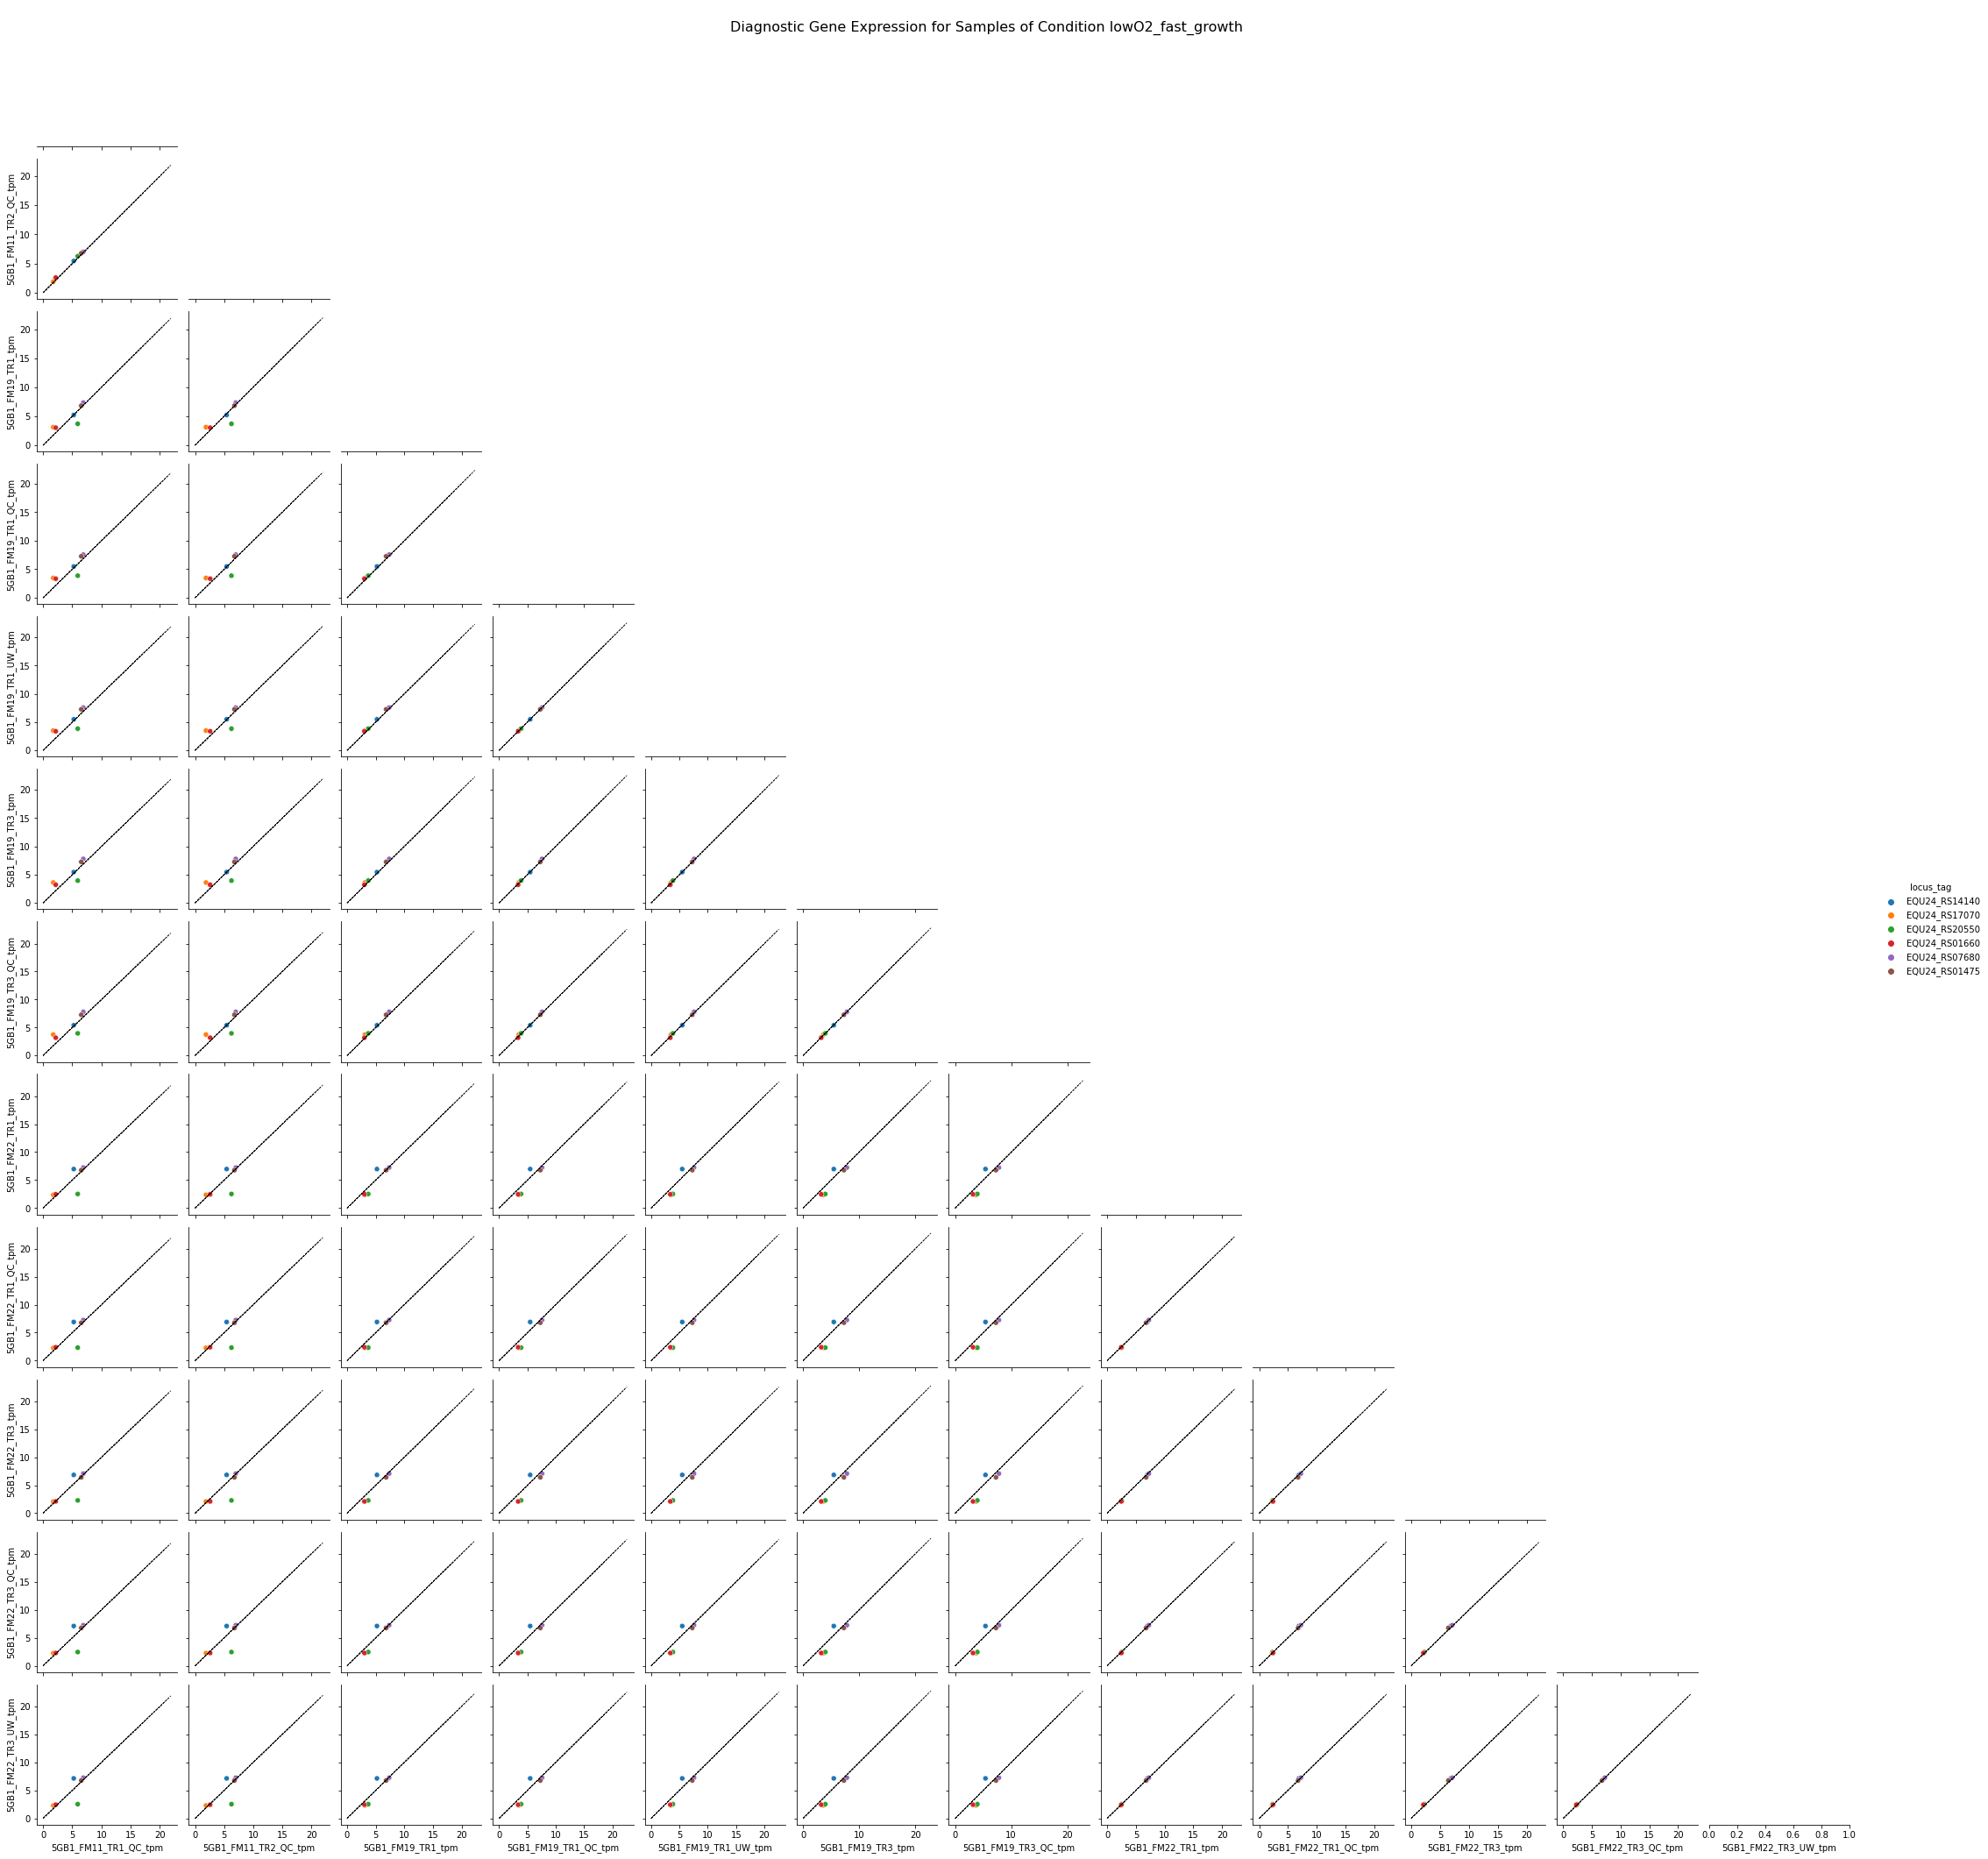

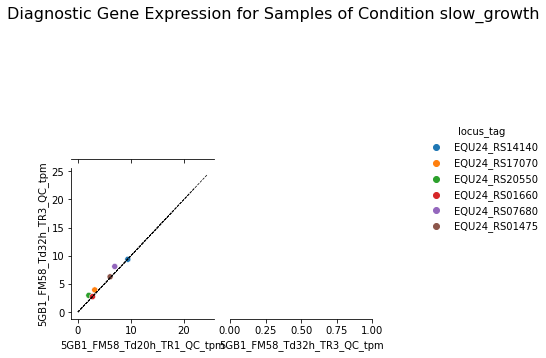

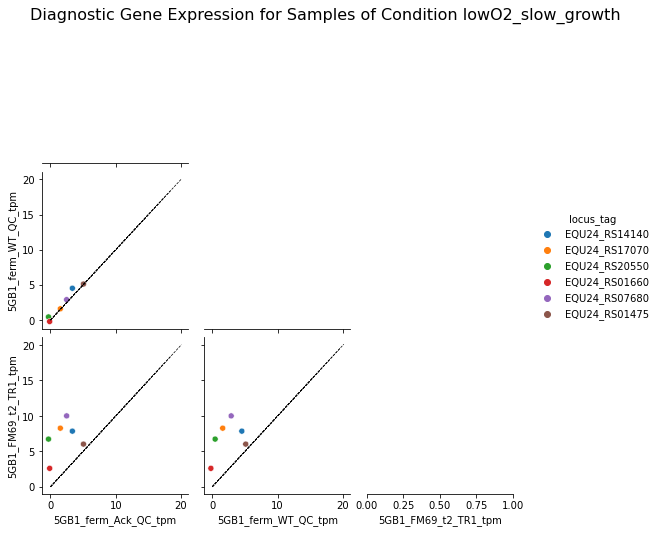

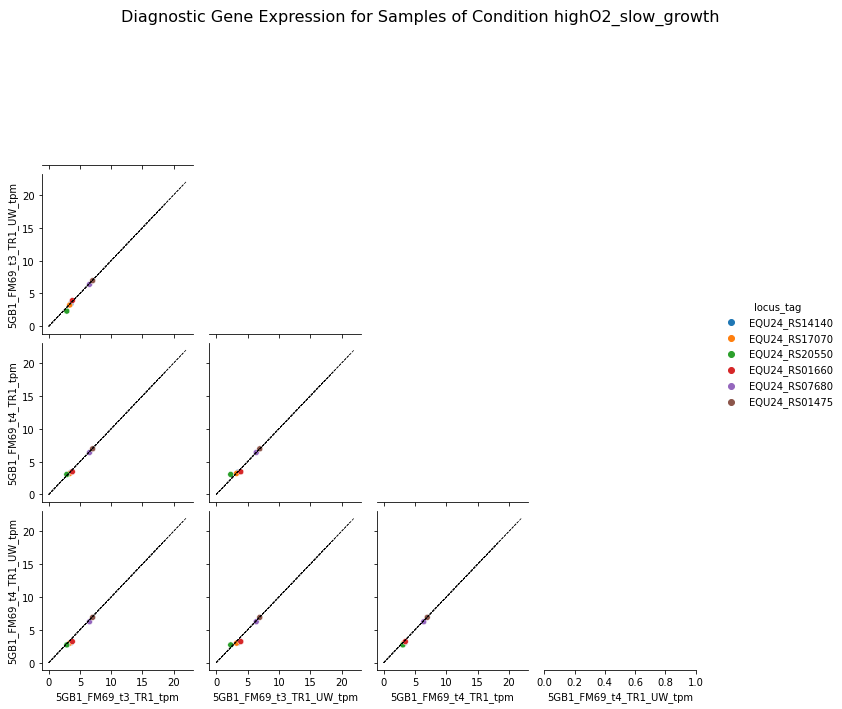

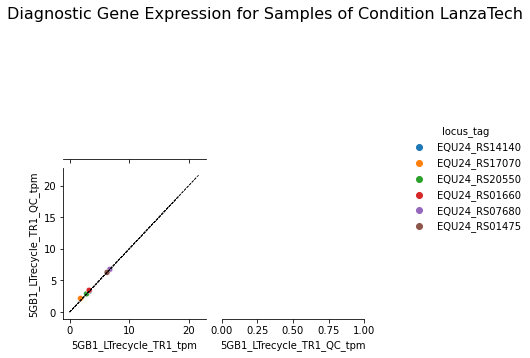

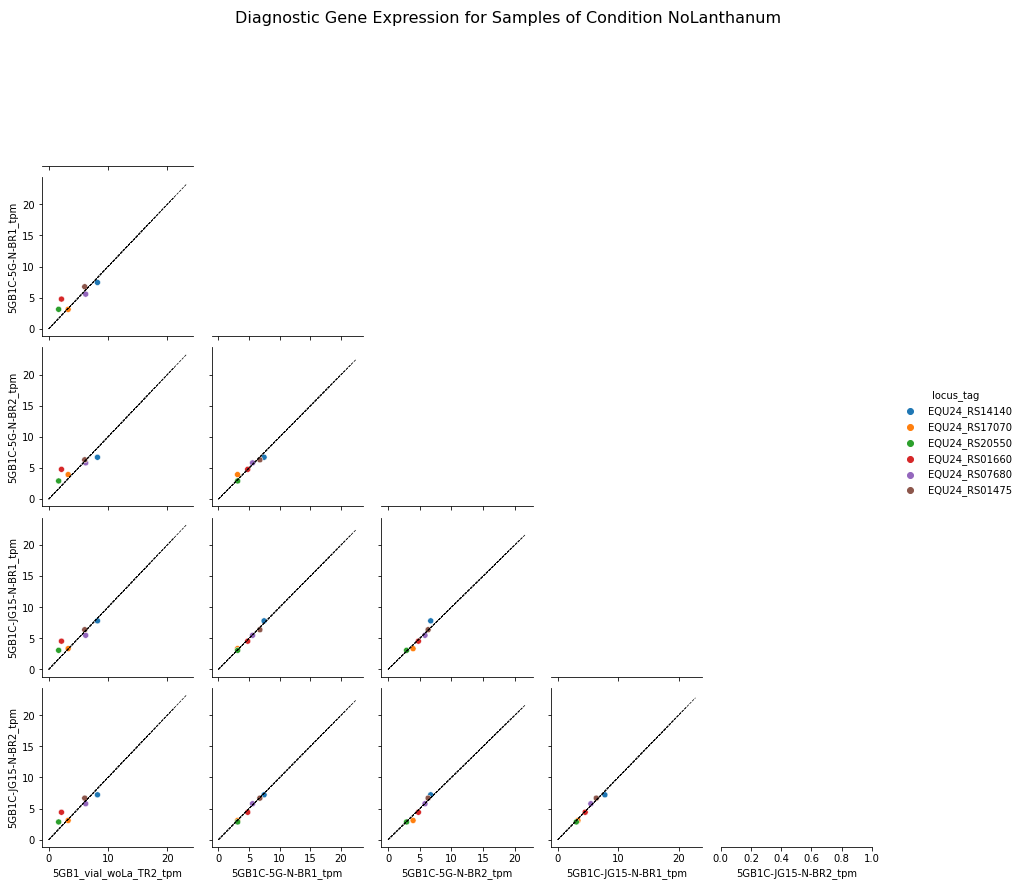

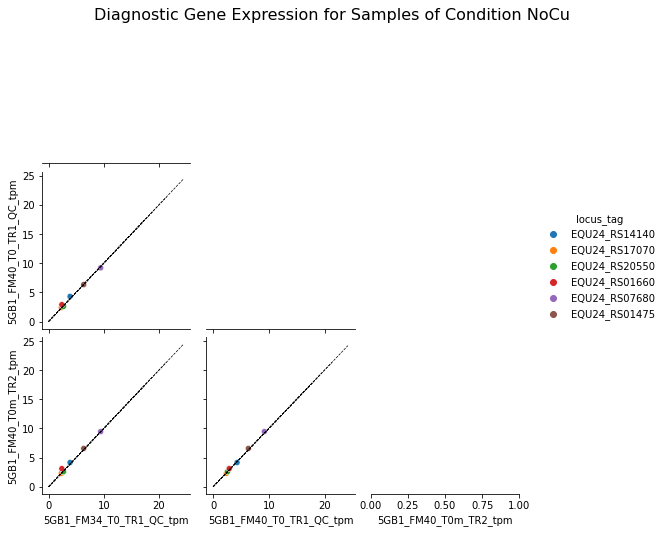

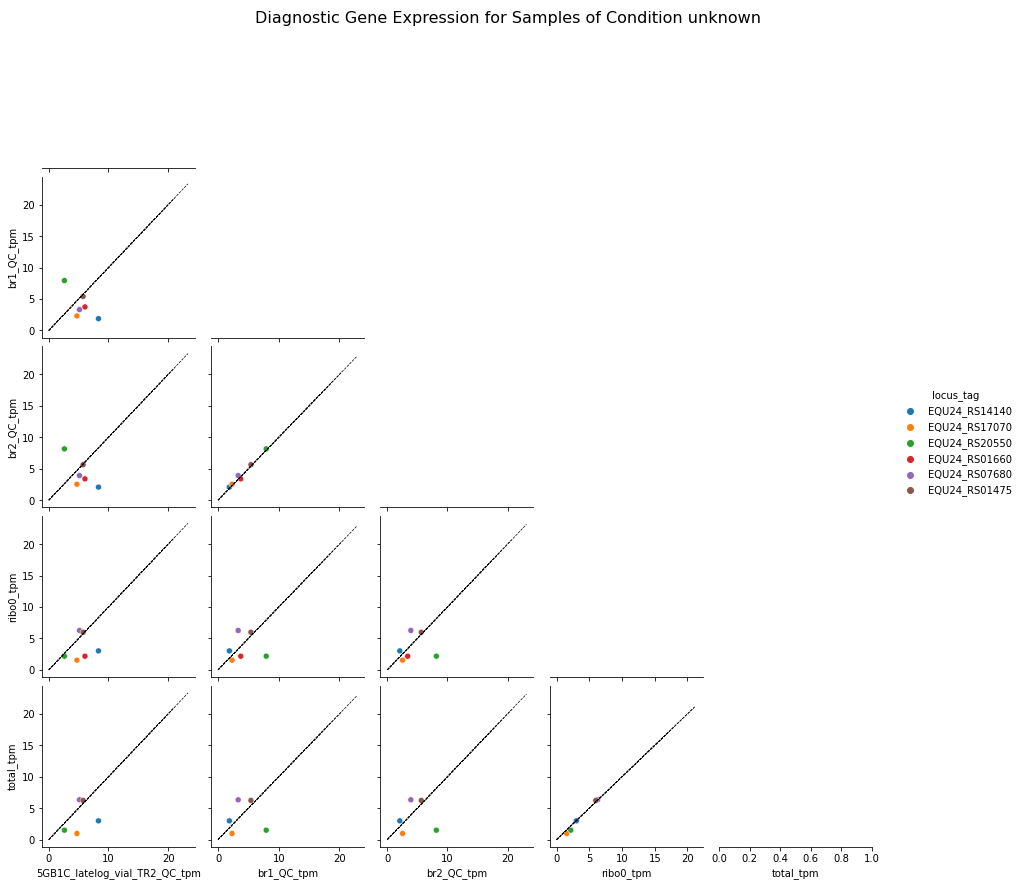

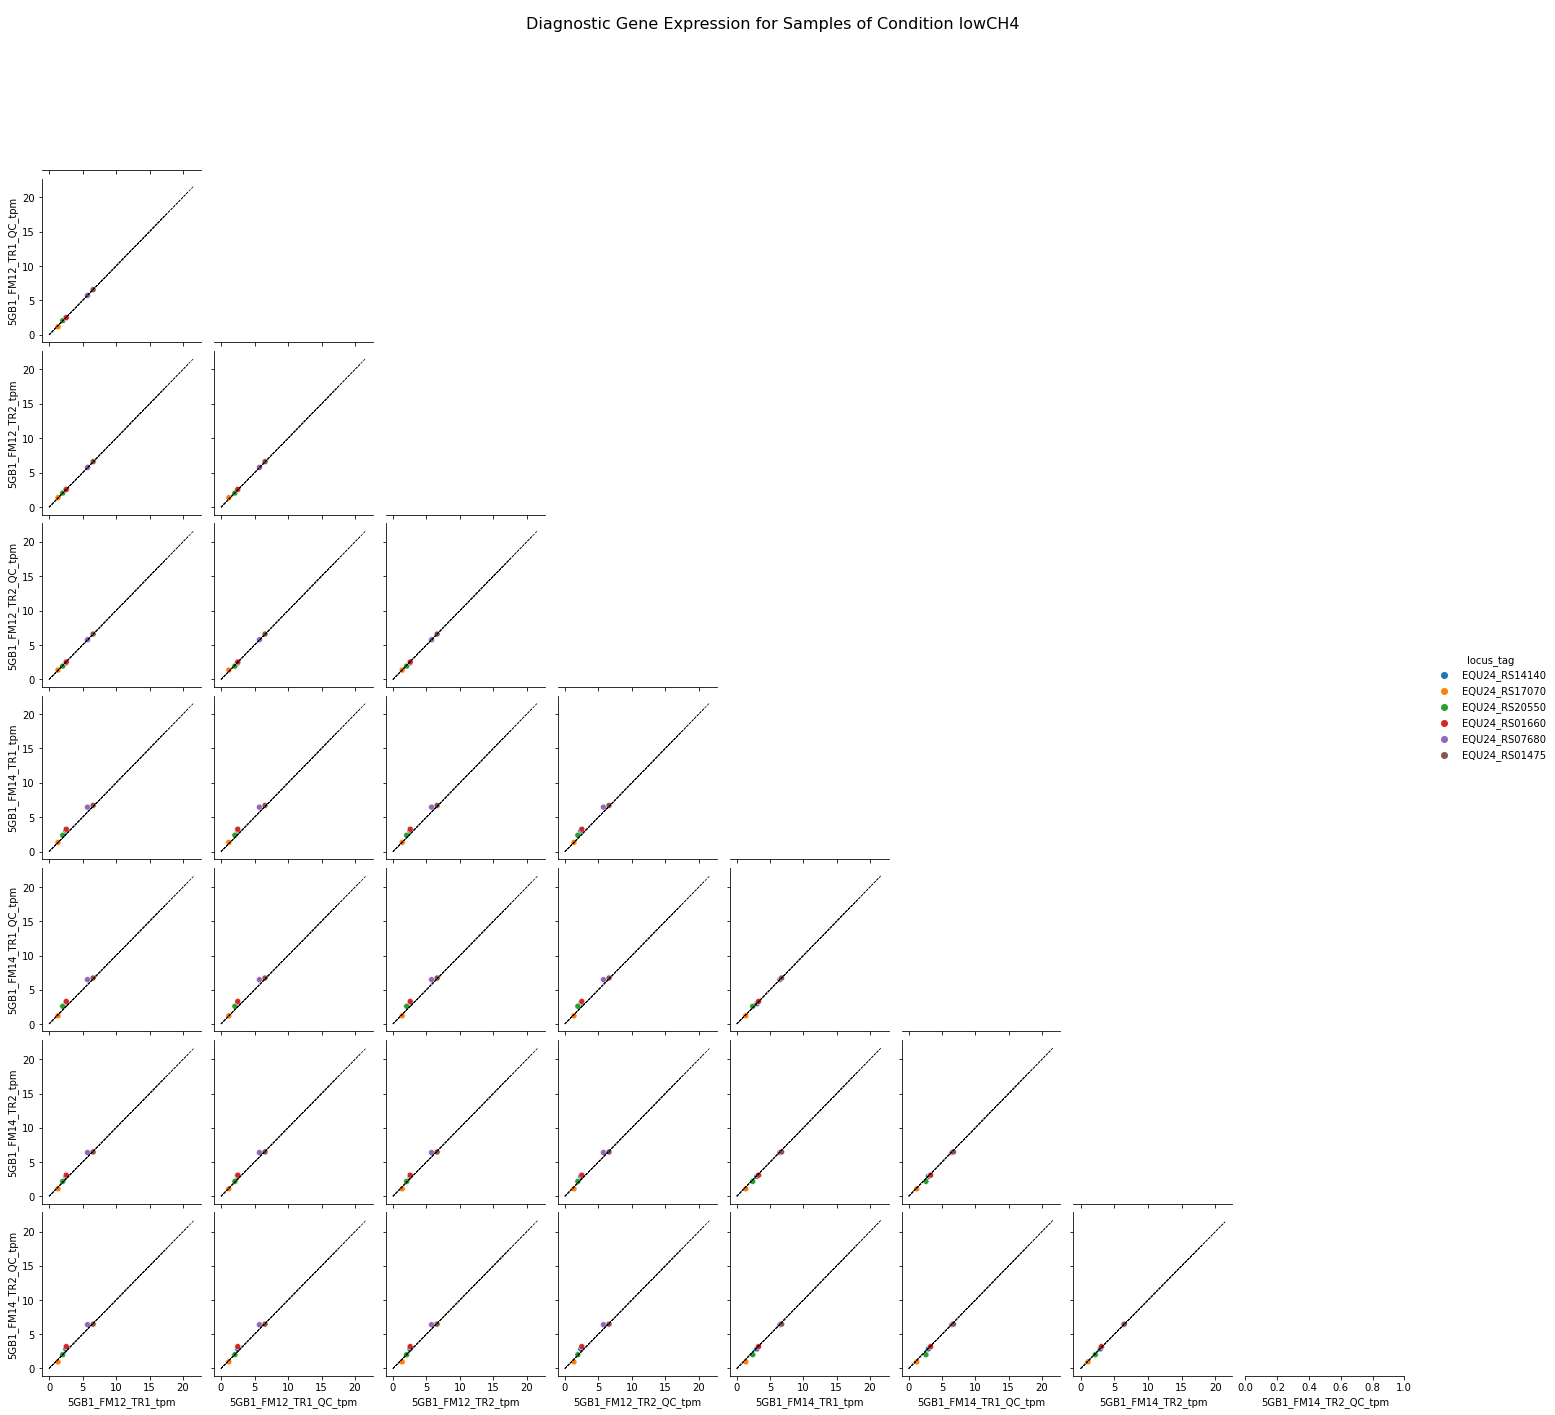

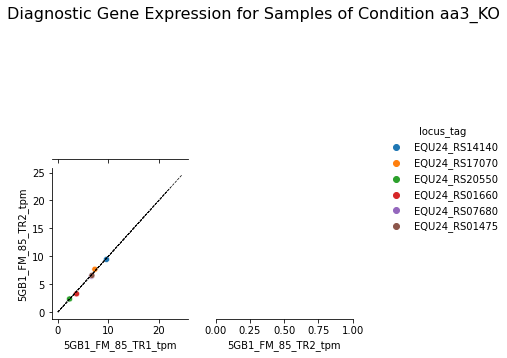

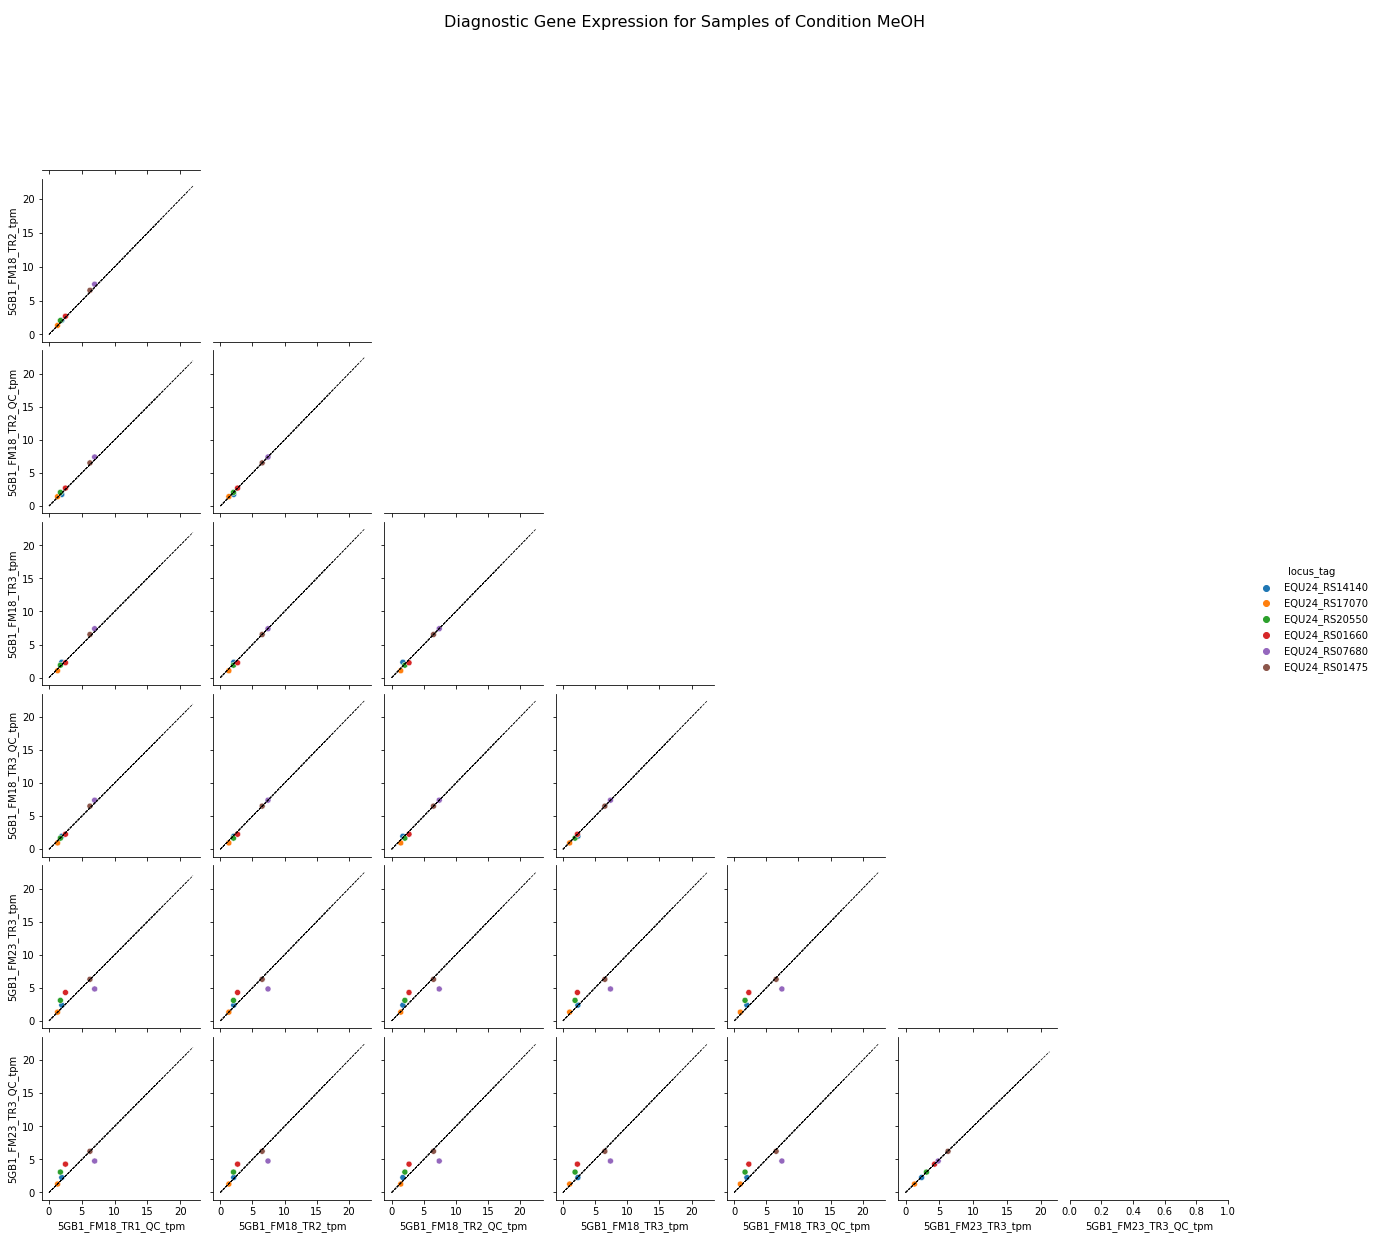

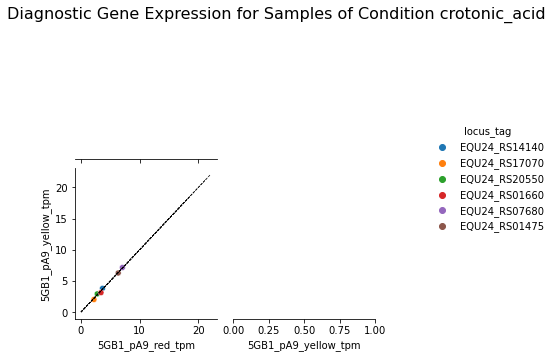

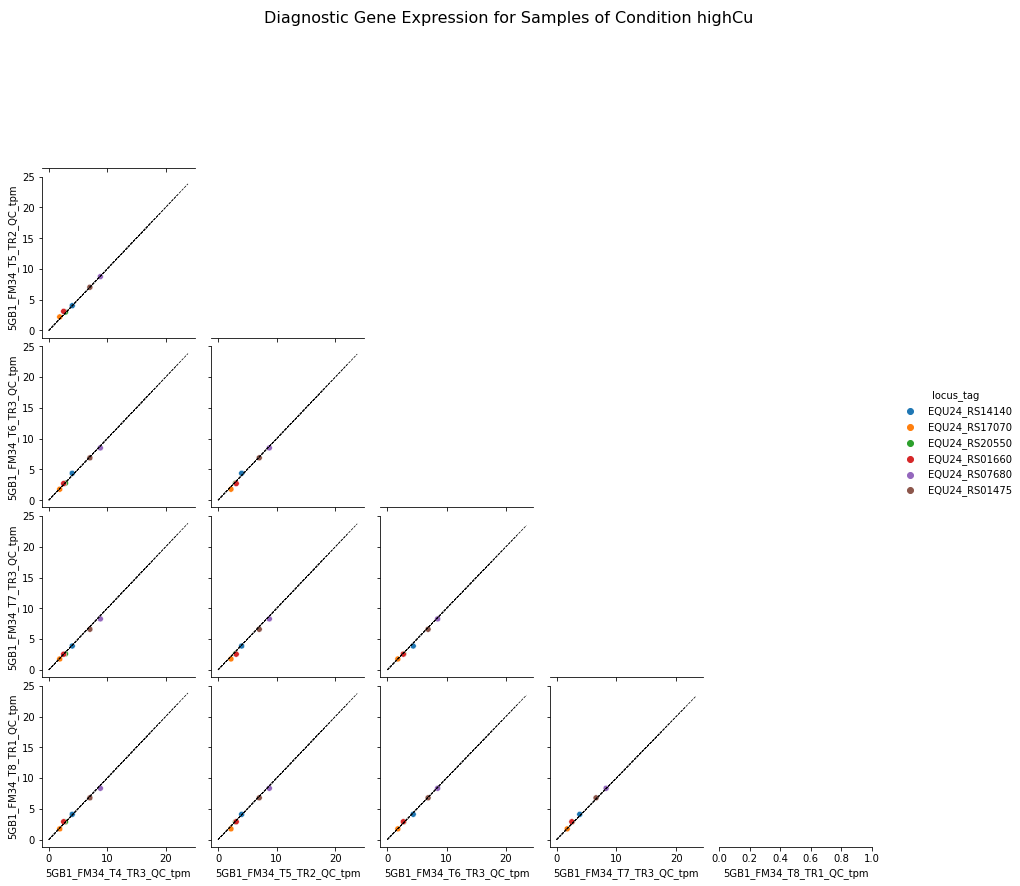

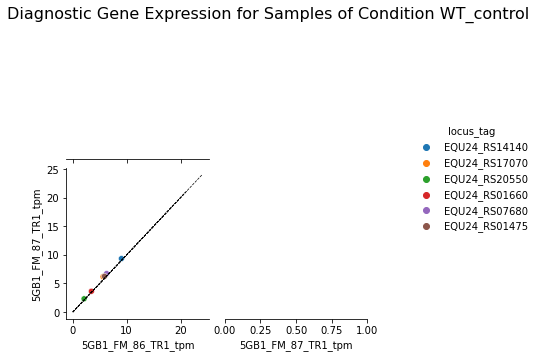

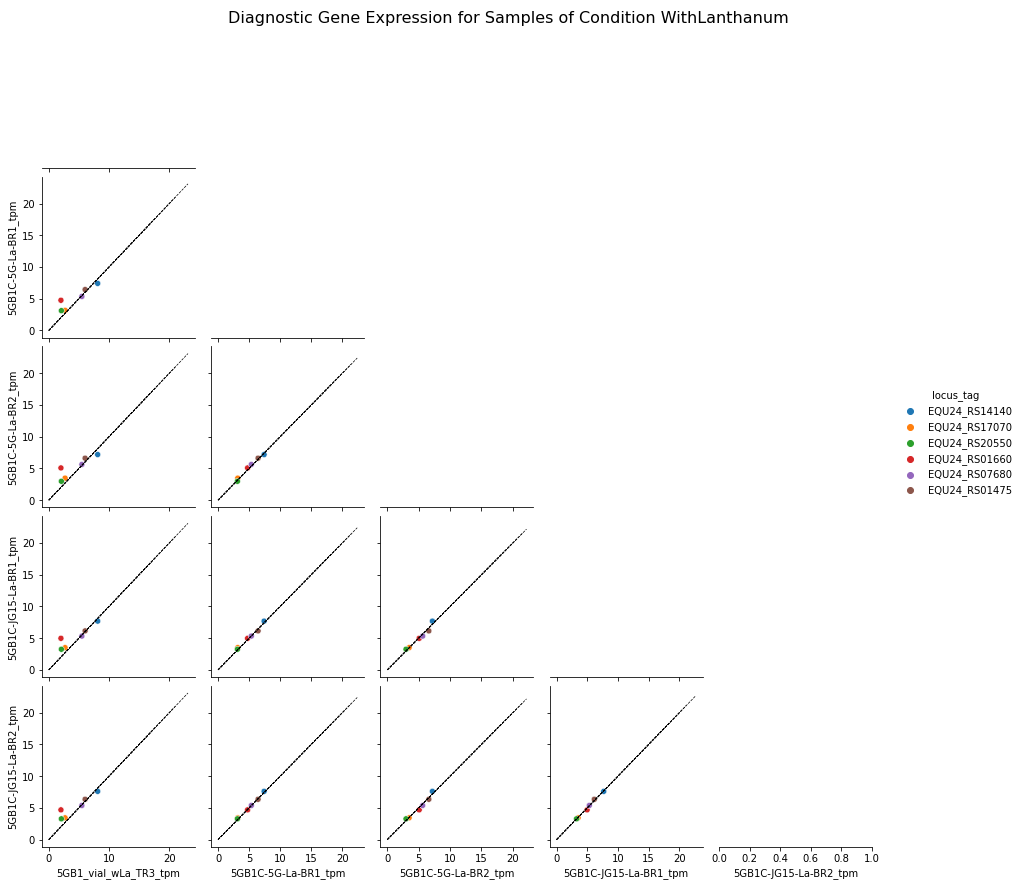

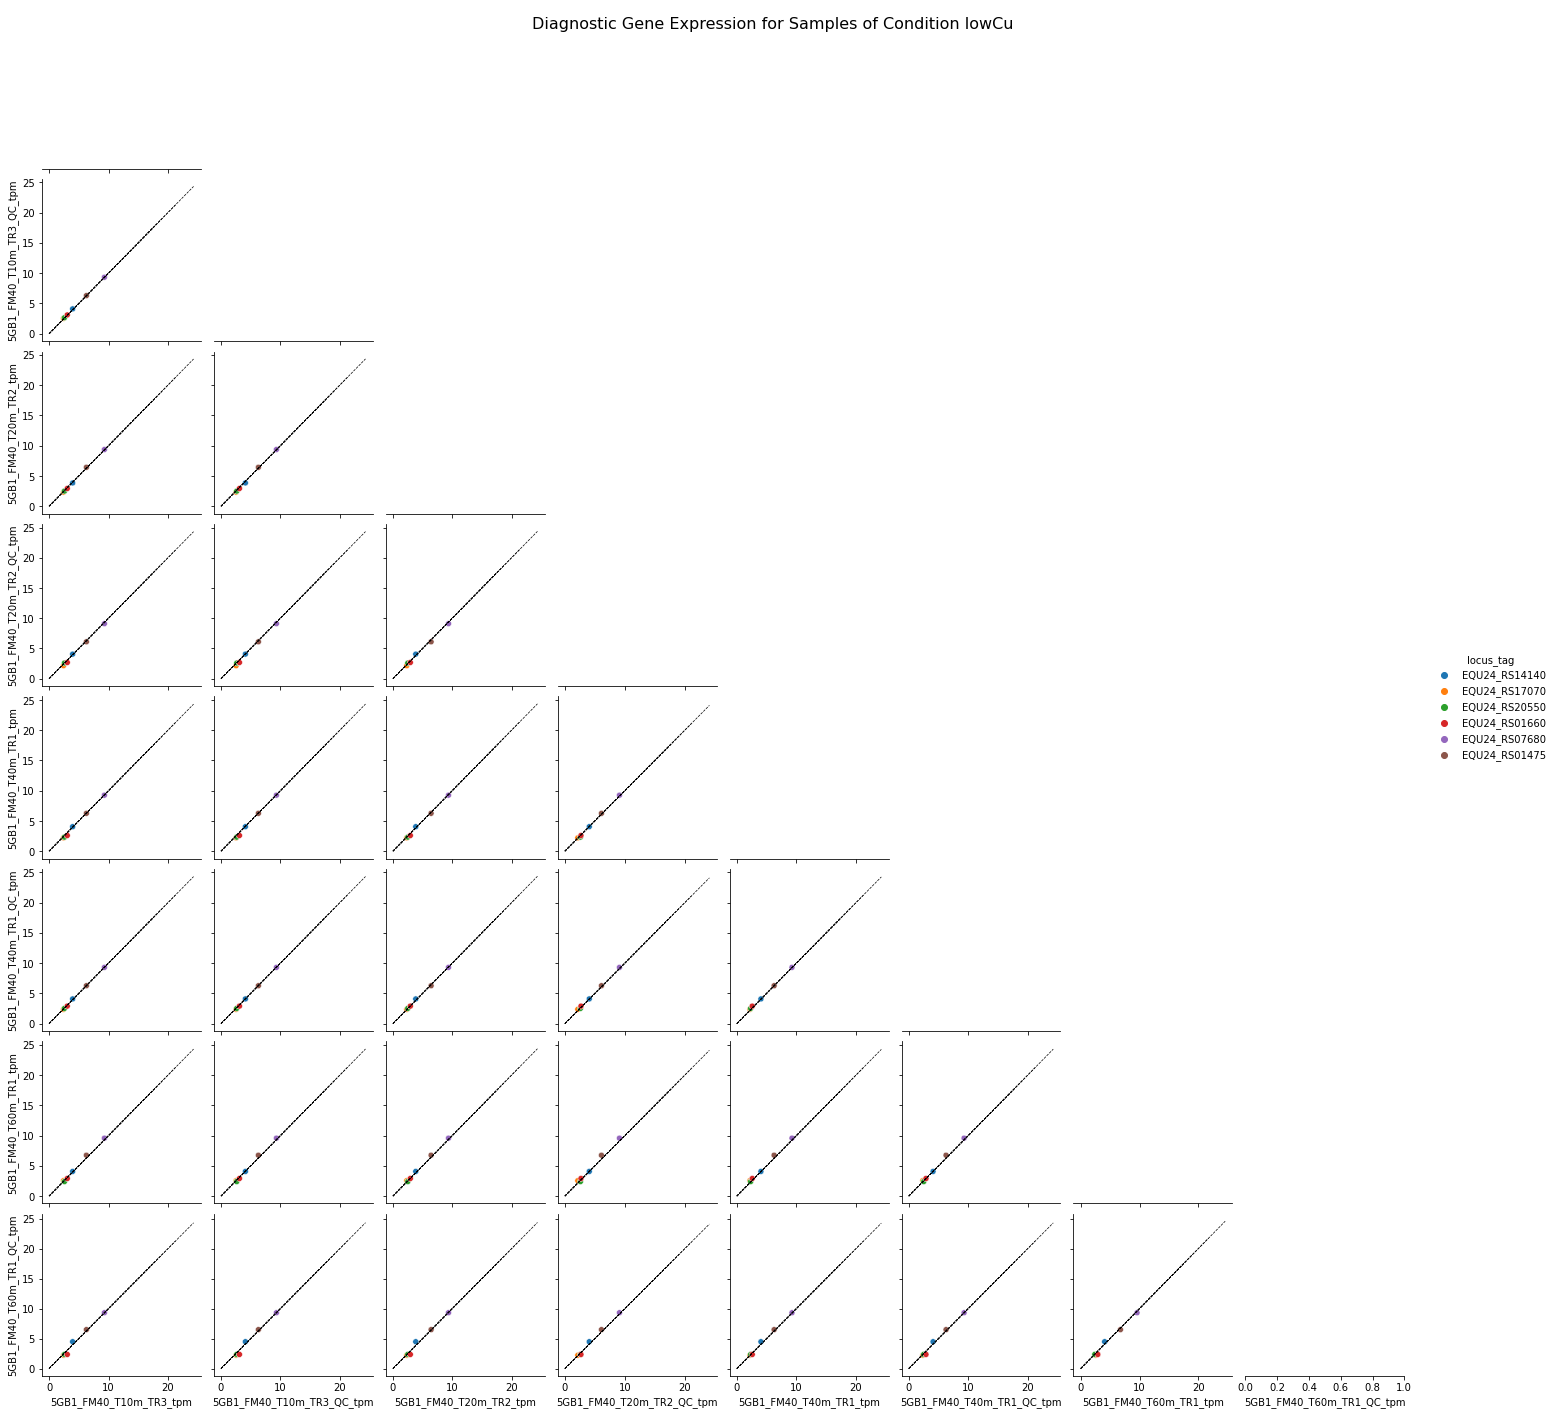

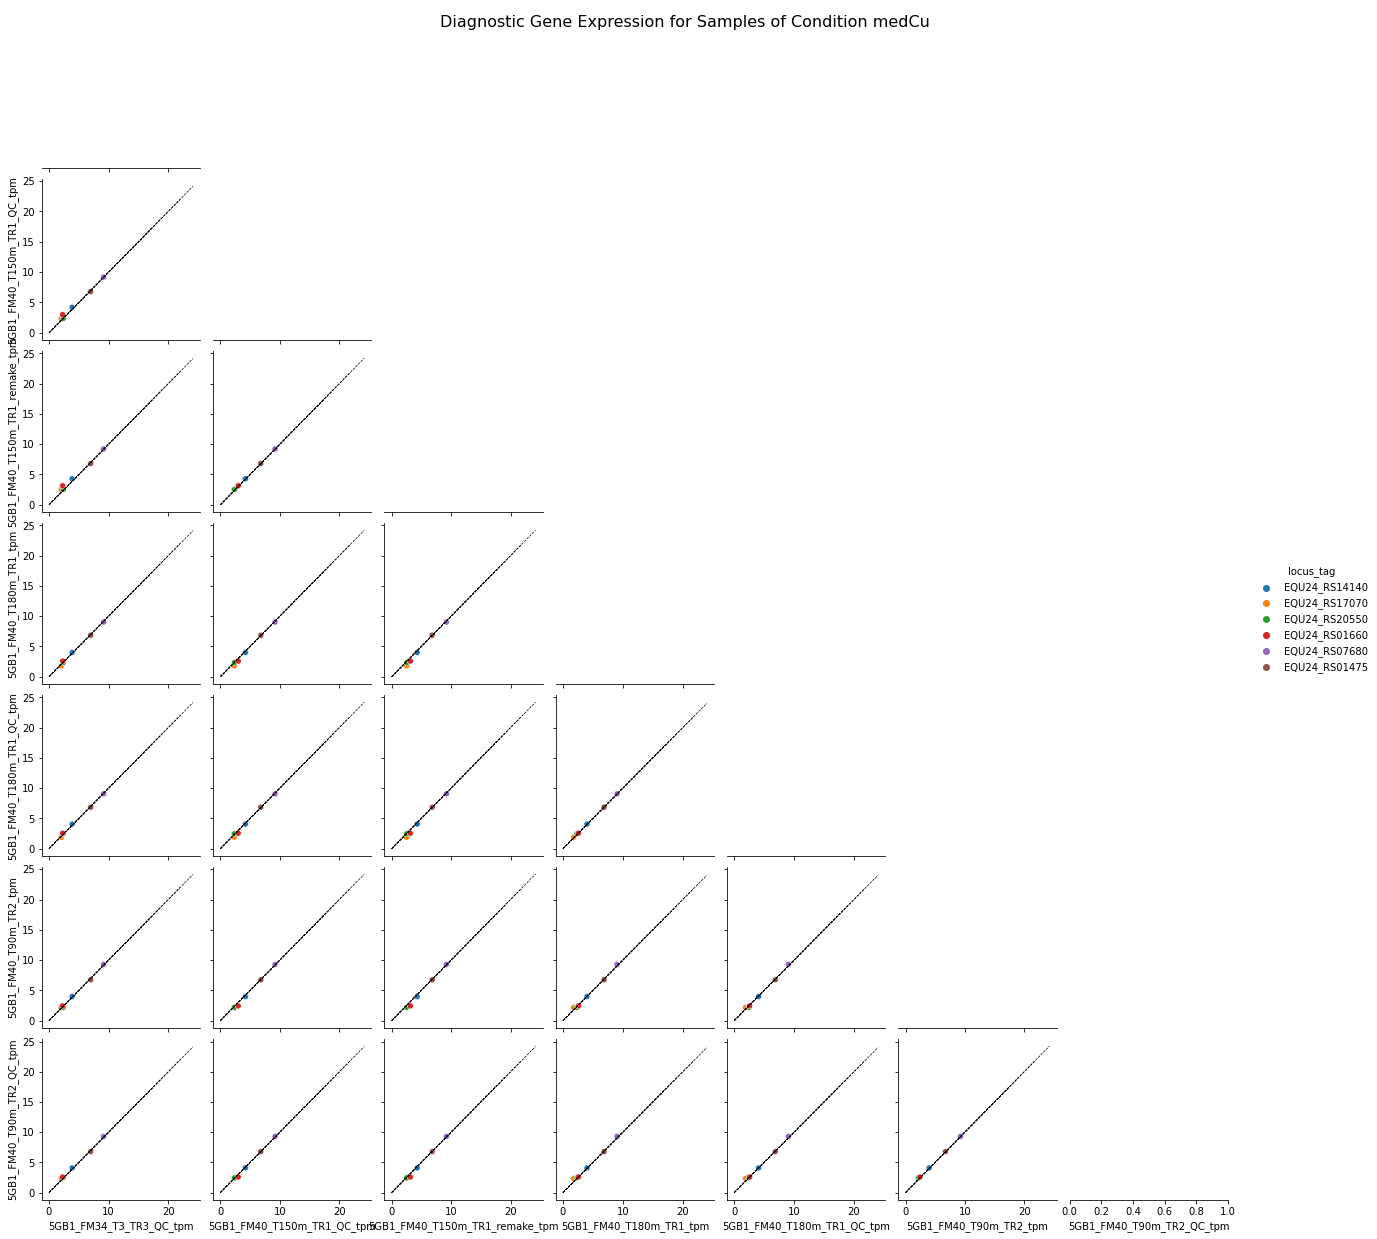

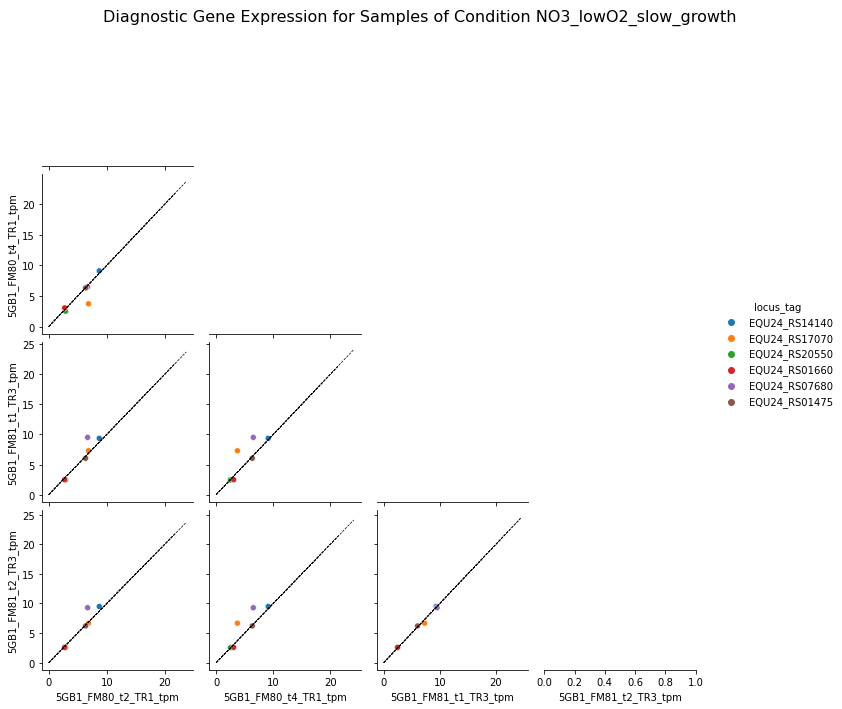

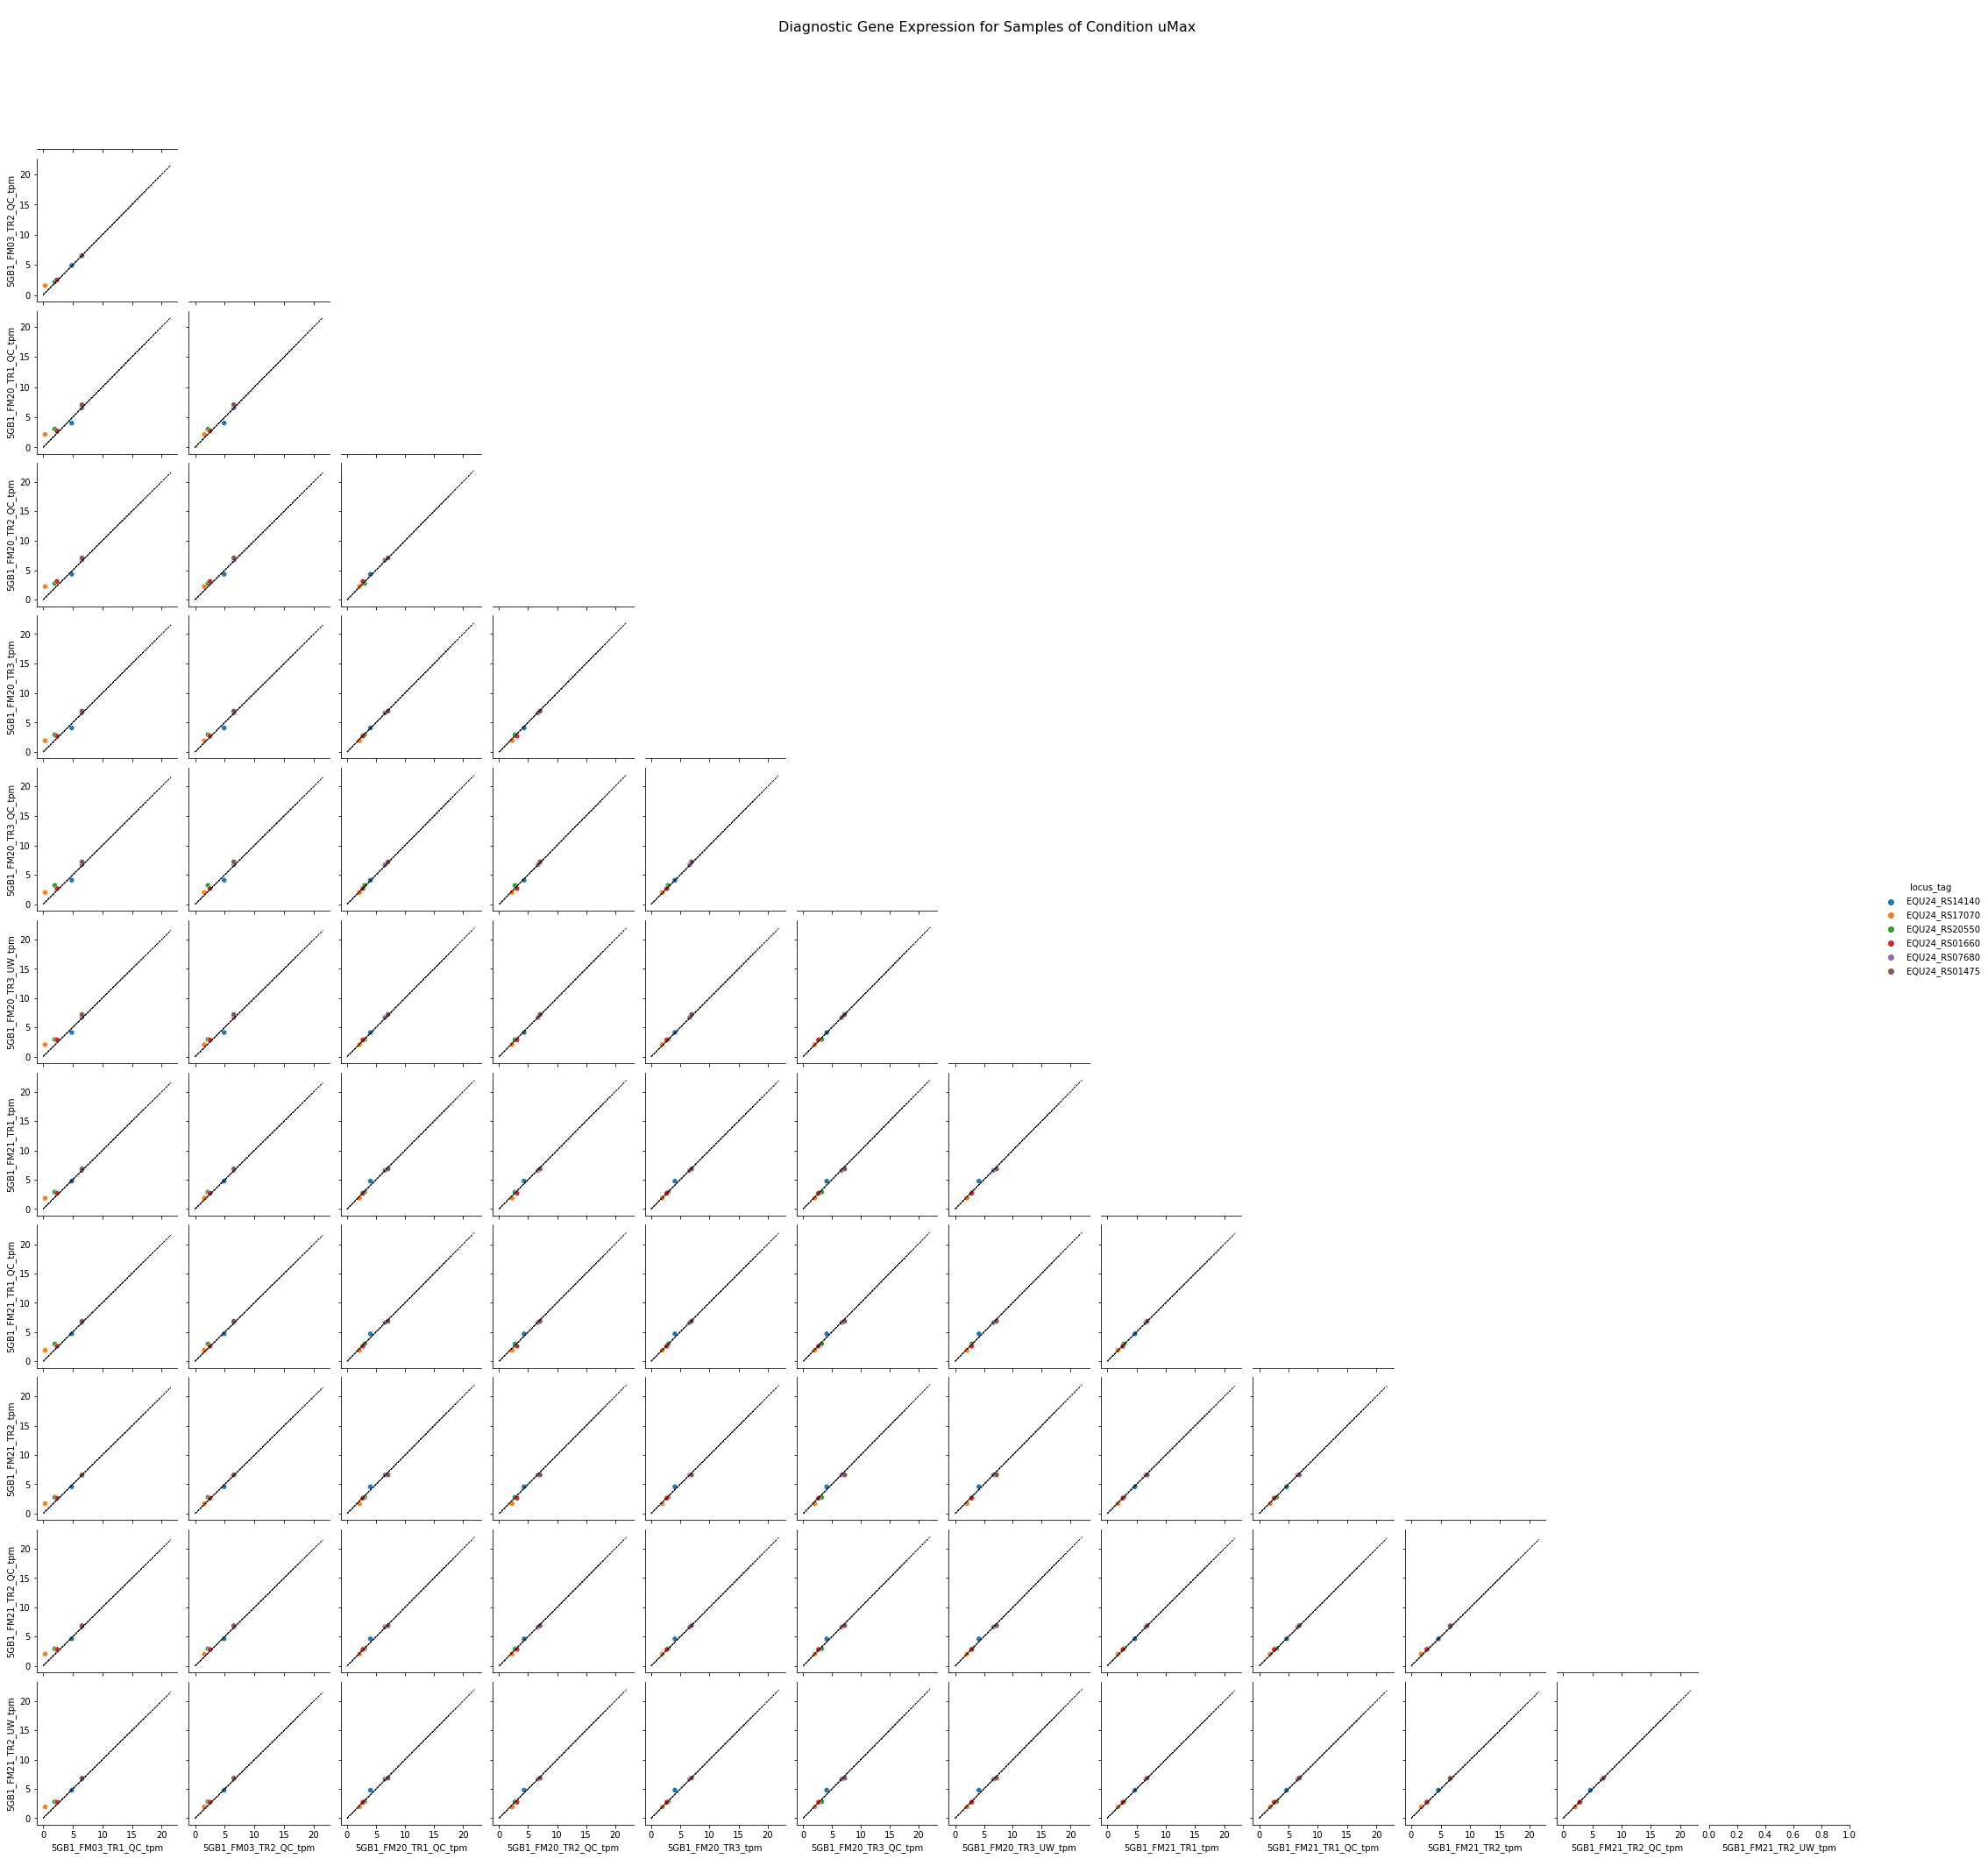

In [517]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for condition in list_conditions: 
        df_cur_condition = np.log(df_all_samples_diag_genes[condition_to_sample.get(condition)])
        df_cur_condition['locus_tag'] = list(df_all_samples_diag_genes.index)
        #df_cur_condition['diagnostic'] = df_cur_condition['locus_tag'].apply(lambda x: gene_to_diagnostic.get(x))

        #           Diagnostic Pairwise + Condition
        filename = "plots/pairwise_expression/diag_pw_" + str(condition)
        title = "Diagnostic Gene Expression for Samples of Condition " + str(condition)
        
        sample_pairwise_scatter(df_cur_condition, title, filename)

## uMax unflagged samples that correlated poorly with other samples
- 5GB1_FM20_TR3_tpm
- 5GB1_FM21_TR2_tpm

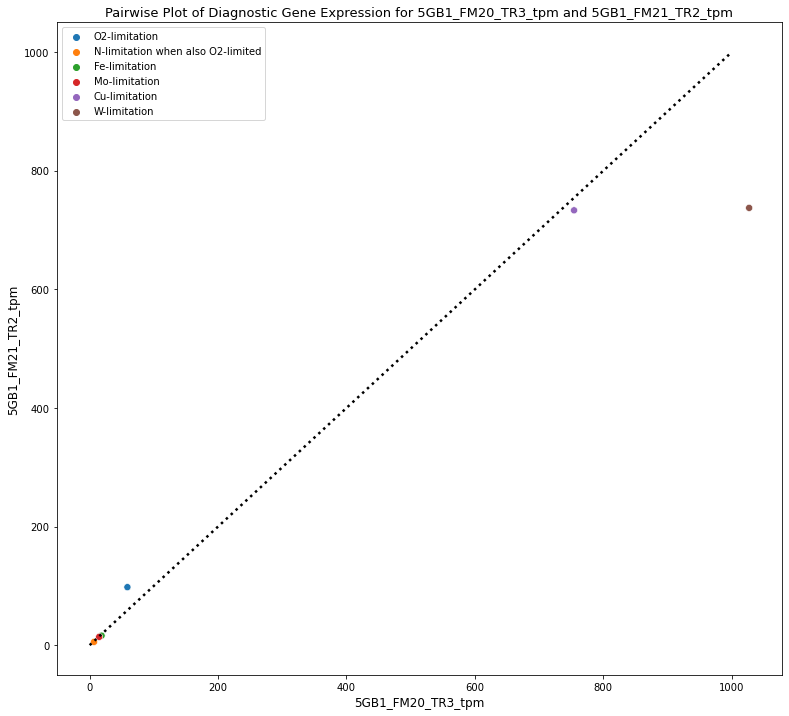

In [21]:
# Highly correlated unflagged samples (that poorly correlated with others)
s1_name =  "5GB1_FM20_TR3_tpm"
s2_name = "5GB1_FM21_TR2_tpm"
max_length = 1000

single_pairwise_scatter(s1_name, s2_name, max_length)

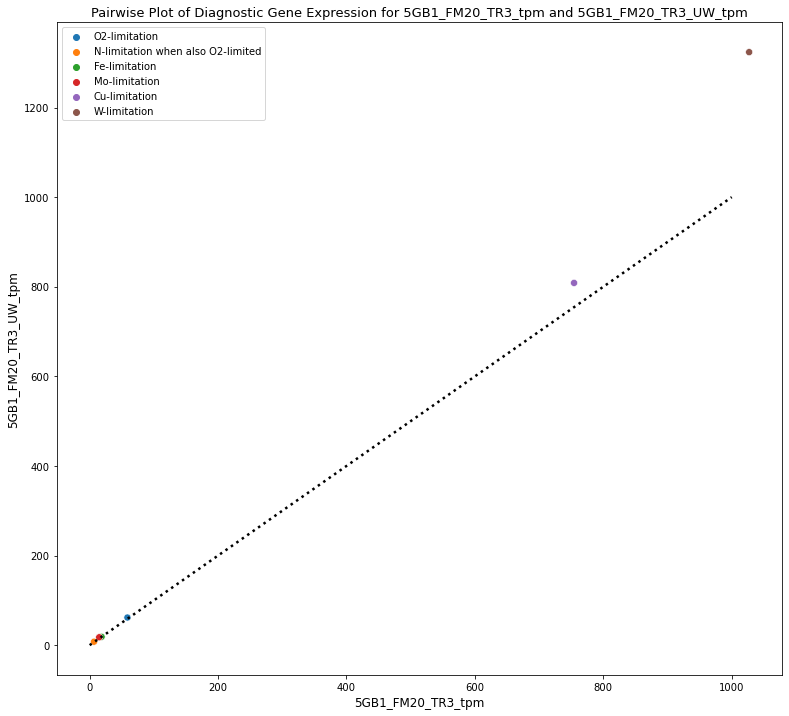

In [22]:
# Relatively less correlated unflagged samples
s1_name =  "5GB1_FM20_TR3_tpm" # Unflagged Exception
s2_name = "5GB1_FM20_TR3_UW_tpm"  # Correlated with majority
max_length = 1000

single_pairwise_scatter(s1_name, s2_name, max_length)

## Gene Cloud Plot

In [23]:
def plot_cloud(s1_name, s2_name, **kws):
    s1 = df_raw_tpm.T[s1_name] + 0.01
    s2 = df_raw_tpm.T[s2_name] + 0.01

    ax = sns.scatterplot(x = np.log(s1), y = np.log(s2), s = 50, alpha = 0.02)

In [24]:
df_raw_tpm.T

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,2.933003,6.033848,48.864921,52.197450,25.751902,34.928170,28.322788,28.461759,28.479425,29.472757,...,38.557373,38.810668,37.444214,40.246006,40.100118,33.432274,39.880174,38.355431,30.247582,41.248441
EQU24_RS00010,1.607784,3.895284,51.315629,54.947425,37.216017,40.094206,27.387700,28.648564,26.498988,26.821965,...,52.552767,52.461746,42.676553,49.210083,46.798476,48.142385,45.465136,46.498139,37.152951,52.902410
EQU24_RS00015,1.415515,2.549771,33.906257,29.979783,21.716802,27.871558,16.570863,15.562811,16.589291,16.958650,...,31.350991,34.914128,21.479309,24.204682,22.171104,22.006566,22.658157,22.753325,19.407103,29.834124
EQU24_RS00020,3.200081,4.301580,64.584281,72.717824,53.032824,55.595529,36.795081,36.401903,37.513079,35.833478,...,74.848501,80.850761,54.959319,64.911376,59.653059,64.648318,69.119079,65.643179,57.590223,68.306759
EQU24_RS00025,1.522728,3.797084,74.801354,62.709260,46.348014,57.992363,27.432559,30.380176,26.852591,26.467246,...,50.324948,49.349547,34.539657,36.521074,37.789611,39.358066,38.992158,35.870964,41.462392,40.227192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,2.300157,3.217944,104.488835,103.864151,78.264069,59.685923,58.833576,57.223346,66.382013,69.196352,...,70.918047,92.044879,20.691249,26.000334,20.753333,30.766617,22.101468,19.753259,20.027390,24.508375
EQU24_RS22140,5.261582,12.526353,379.686212,401.742811,208.094267,210.820167,204.760175,204.759505,211.282600,218.557992,...,328.789579,403.009110,105.587429,138.423469,100.648922,166.101675,96.169044,93.527806,89.780995,130.851229
EQU24_RS22145,9.389775,21.072962,500.129230,495.262554,260.011454,331.355028,300.766500,309.148602,312.637538,317.603906,...,301.203428,329.903989,69.198876,75.440610,62.460976,59.523445,47.641158,60.667488,55.739018,66.415222


In [25]:
# Intention: Plot the diagnostic genes along side the respective gene clouds. 
# Error: resulting plot is too large supposedly ==> will investigate!

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    df_raw_tpm_psuedocount = df_raw_tpm.T + 0.01
    df_diag_condition = df_all_samples_diag_genes + 0.01
    
    condition = "LanzaTech"
    #for condition in list_conditions: 
    df_diag_condition = np.log(df_all_samples_diag_genes[condition_to_sample.get(condition)])
    df_diag_condition['locus_tag'] = list(df_all_samples_diag_genes.index)
    
    df_cur_condition = np.log(df_raw_tpm_psuedocount[condition_to_sample.get(condition)])
    df_cur_condition["locus_tag"] = df_cur_condition.index

    #           Diagnostic Pairwise + Condition
    filename = "plots/pairwise_expression/gene_cloud_pw_" + str(condition)
    title = "Diagnostic Gene Expression for Samples of Condition " + str(condition)

    sample_pairwise_scatter(df_diag_condition, df_cur_condition, title, filename)


TypeError: sample_pairwise_scatter() takes 3 positional arguments but 4 were given

In [26]:
df_raw_tpm_psuedocount = df_raw_tpm.T + 0.01
for condition in list_conditions: 
    df_cur_condition = np.log(df_raw_tpm_psuedocount[condition_to_sample.get(condition)])

df_cur_condition

,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm
locus_tag,,
EQU24_RS00005,3.652407,3.658953
EQU24_RS00010,3.962008,3.960275
EQU24_RS00015,3.445565,3.553178
EQU24_RS00020,4.315600,4.392729
EQU24_RS00025,3.918700,3.899131
...,...,...
EQU24_RS22135,4.261666,4.522385
EQU24_RS22140,5.795448,5.998984
EQU24_RS22145,5.707819,5.798832


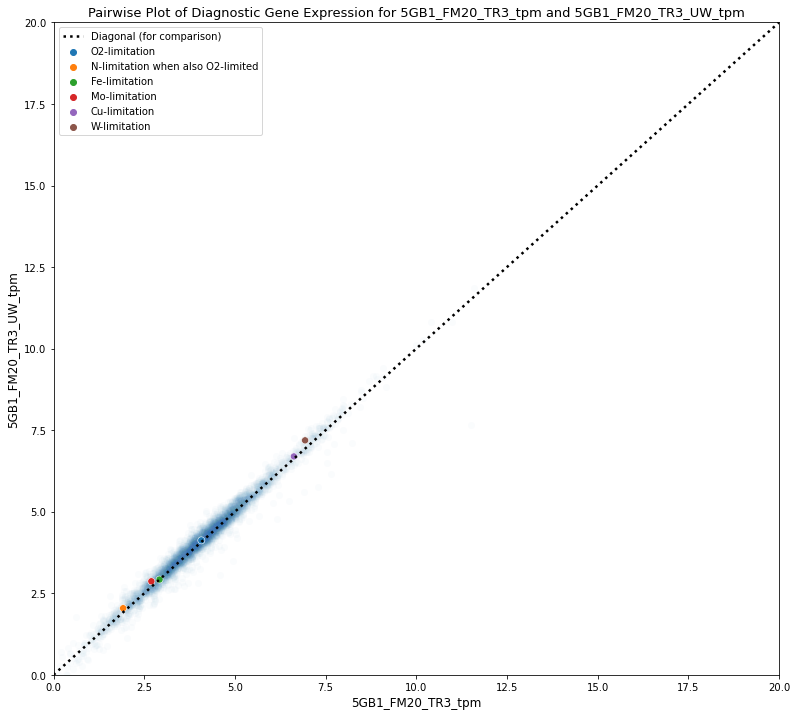

In [423]:
s1_name =  "5GB1_FM20_TR3_tpm" # Unflagged Exception
s2_name = "5GB1_FM20_TR3_UW_tpm"  # Correlated with major

plt.figure(figsize=(13, 12))


s1 = df_raw_tpm.T[s1_name] + 0.01
s2 = df_raw_tpm.T[s2_name] + 0.01

max_length = 20
ax = sns.scatterplot(x = np.log(s1), y = np.log(s2), s = 50, alpha = 0.02)
line = plt.plot([0, max_length],[0, max_length], color = "black", lw = 2.5, linestyle = ":", label = "Diagonal (for comparison)")


s1 = df_all_samples_diag_genes[s1_name]
s2 = df_all_samples_diag_genes[s2_name]

ax = sns.scatterplot(x = np.log(s1), y = np.log(s2), s = 50, hue = gene_to_diagnostic)
# line = plt.plot([0, max_length],[0, max_length], color = "black", lw = 2.5, linestyle = ":", label = "Diagonal (for comparison)")

plt.xlabel(s1_name, fontsize = 12)
plt.ylabel(s2_name, fontsize = 12)

# plt.xlim = (0, 1000)
# plt.ylim = (0, 1000)
ax.set(ylim=(0, max_length))
ax.set(xlim=(0, max_length))

plt.title("Pairwise Plot of Diagnostic Gene Expression for "  + s1_name +" and " + s2_name, fontsize = 13)

plt.show()


## Individual Samples of Interest Visualized

In [27]:
df_unstable_diag_samples

,Condition,Sample 1,Sample 2,Summary_Name
0,MeOH,5GB1_FM18_TR1_QC_tpm,5GB1_FM23_TR3_QC_tpm,FM18_TR1_FM23_TR3
1,NO3_lowO2_slow_growth,5GB1_FM80_t2_TR1_tpm,5GB1_FM81_t2_TR3_tpm,FM80_TR1_FM81_TR3
2,NO3_lowO2_slow_growth,5GB1_FM80_t2_TR1_tpm,5GB1_FM80_t4_TR1_tpm,FM80_t2_FM80_t4
3,NO3_lowO2_slow_growth,5GB1_FM80_t4_TR1_tpm,5GB1_FM81_t2_TR3_tpm,FM80_t4_FM81_t2
4,NoLanthanum,5GB1C-JG15-N-BR2_tpm,5GB1_vial_woLa_TR2_tpm,JG15_woLa_TR2
5,WithLanthanum,5GB1_vial_wLa_TR3_tpm,5GB1C-JG15-La-BR2_tpm,wLa_TR3_JG15
6,lowO2_fast_growth,5GB1_FM11_TR2_QC_tpm,5GB1_FM19_TR3_tpm,FM11_TR2_FM19_TR3
7,lowO2_fast_growth,5GB1_FM22_TR3_UW_tpm,5GB1_FM11_TR2_QC_tpm,FM22_TR3_FM11_TR2
8,lowO2_slow_growth,5GB1_ferm_Ack_QC_tpm,5GB1_FM69_t2_TR1_tpm,ferm_Ack_FM69_TR1
9,uMax,5GB1_FM03_TR1_QC_tpm,5GB1_FM21_TR2_UW_tpm,FM03_TR1_FM21_TR2


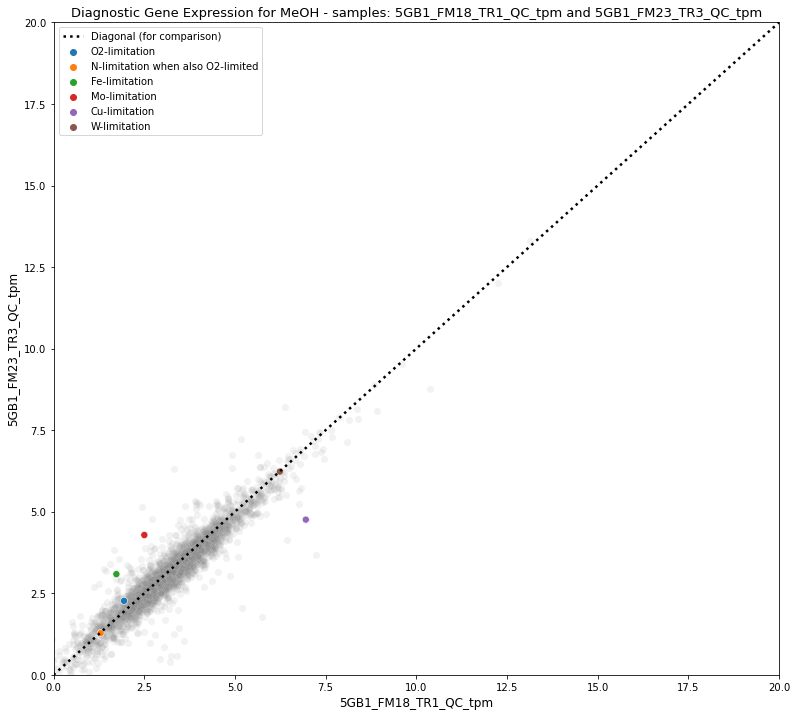

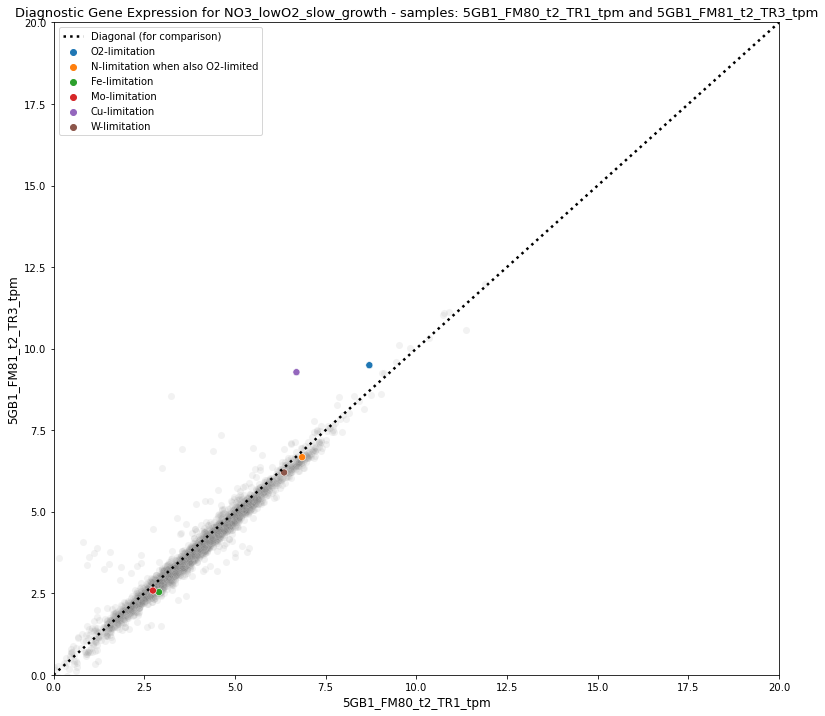

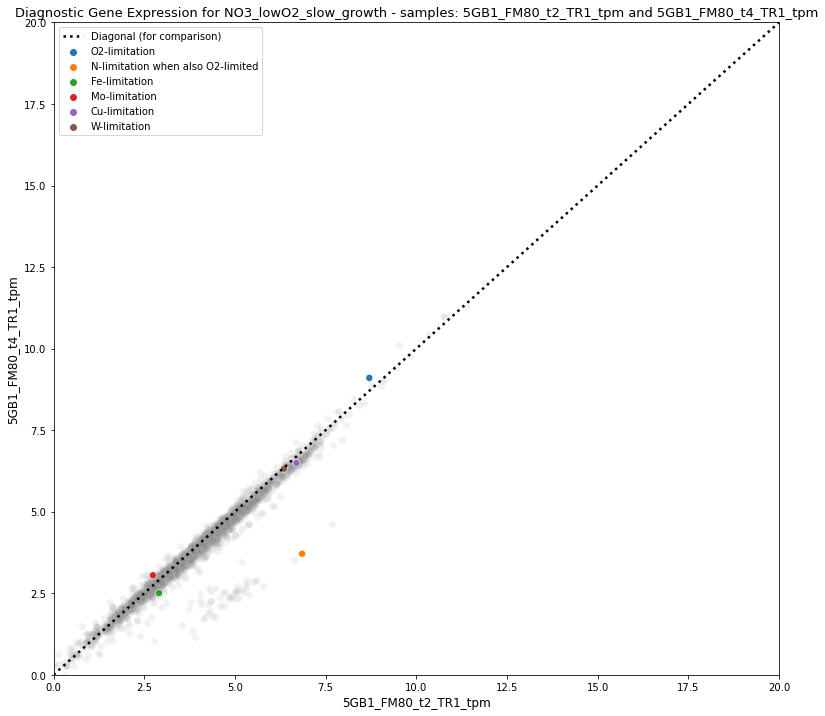

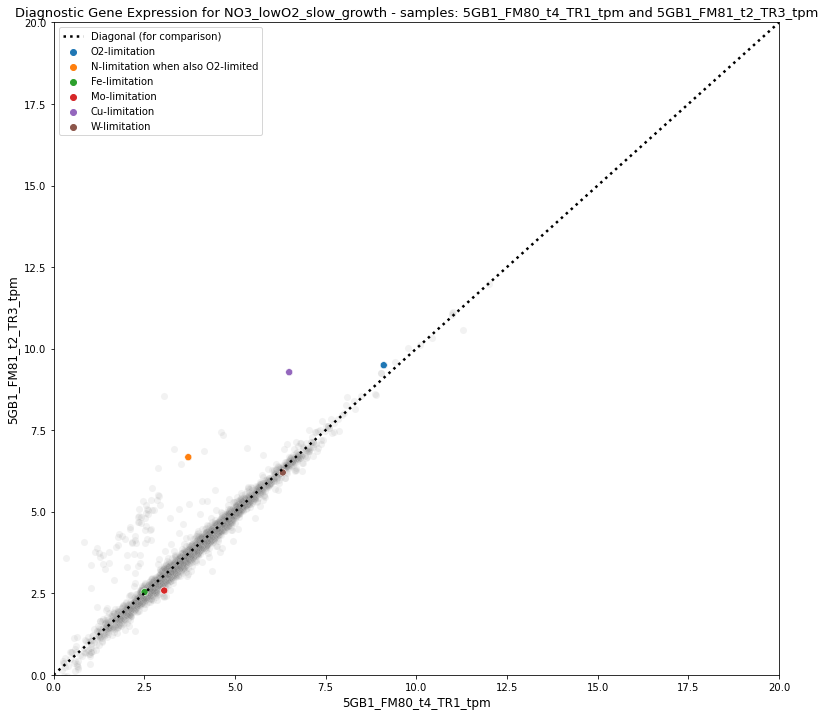

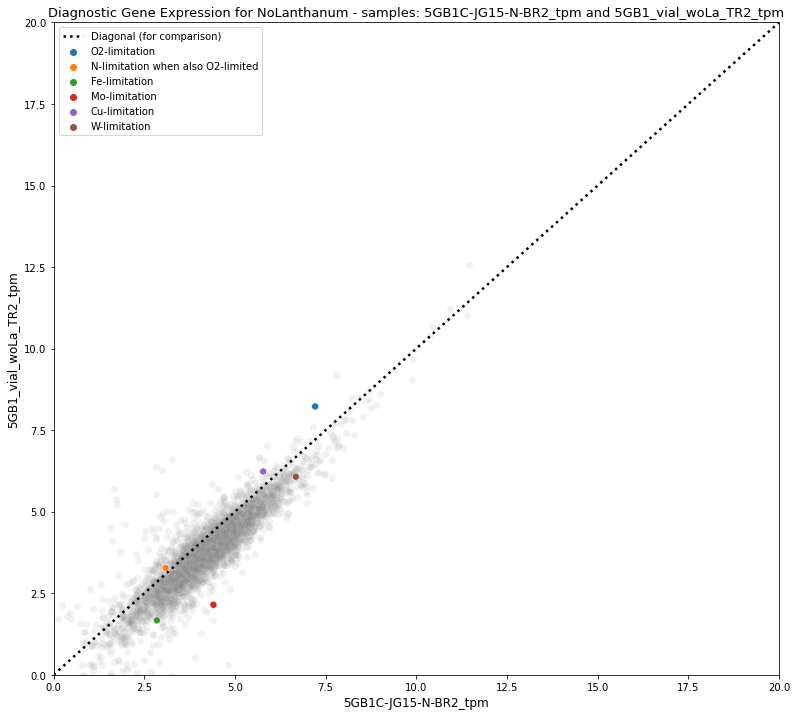

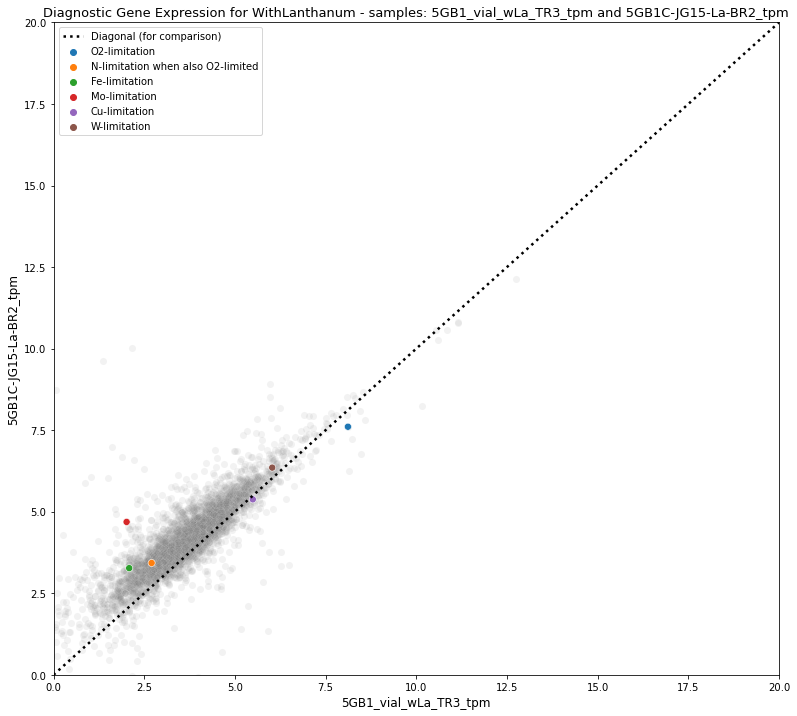

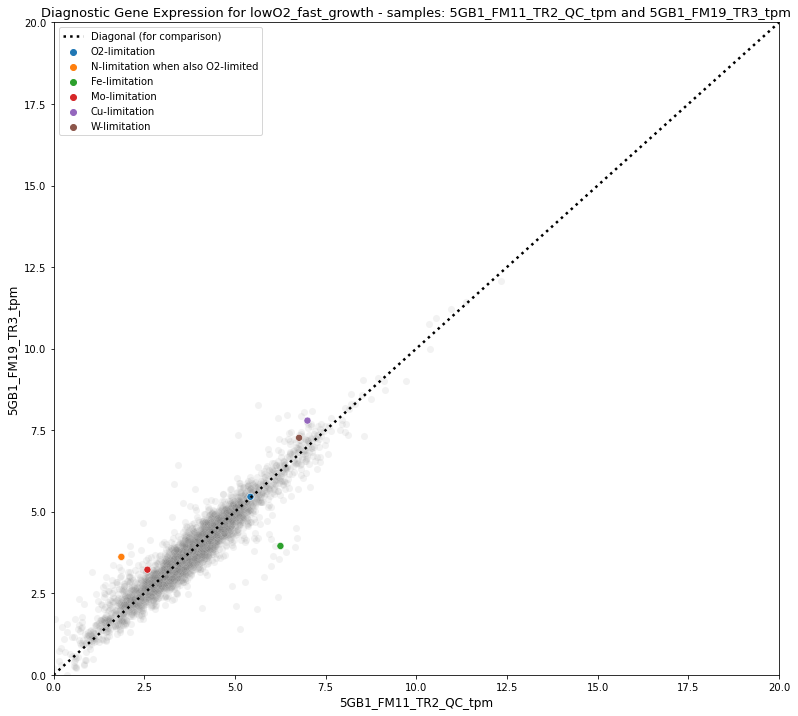

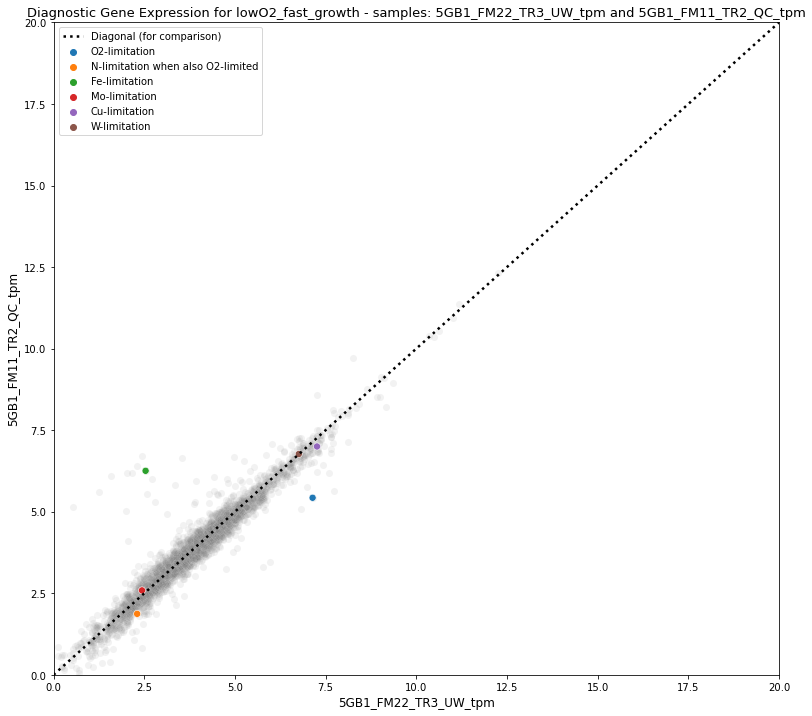

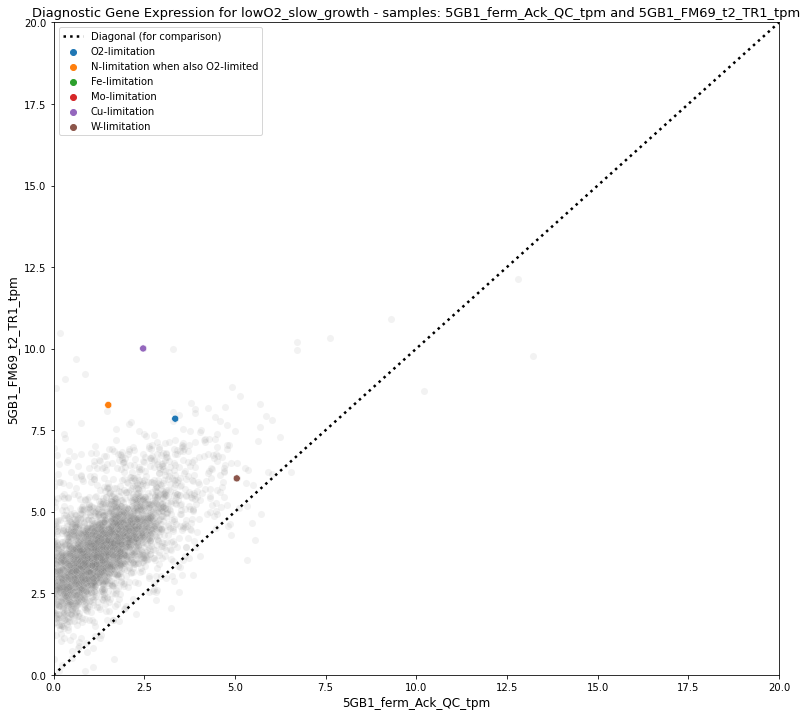

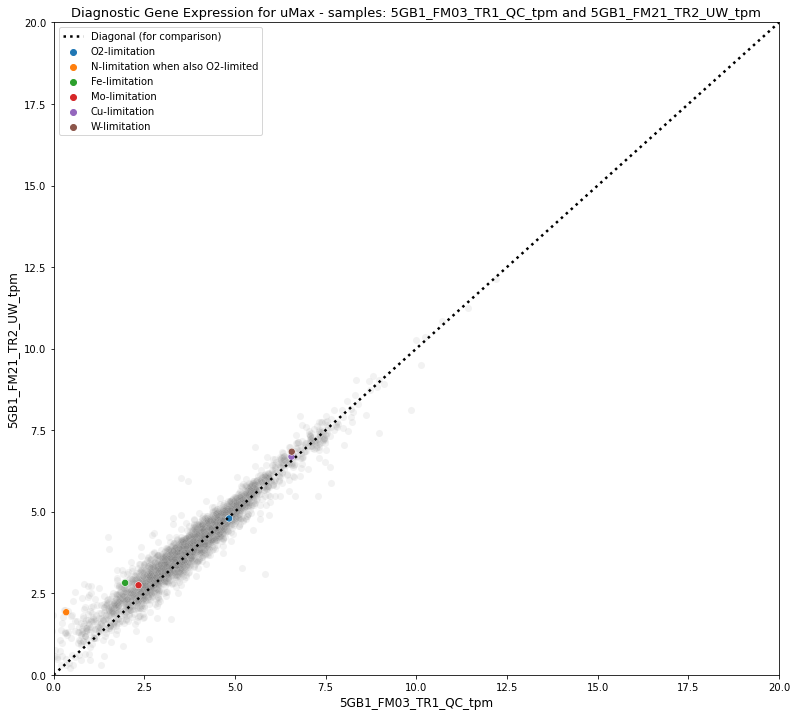

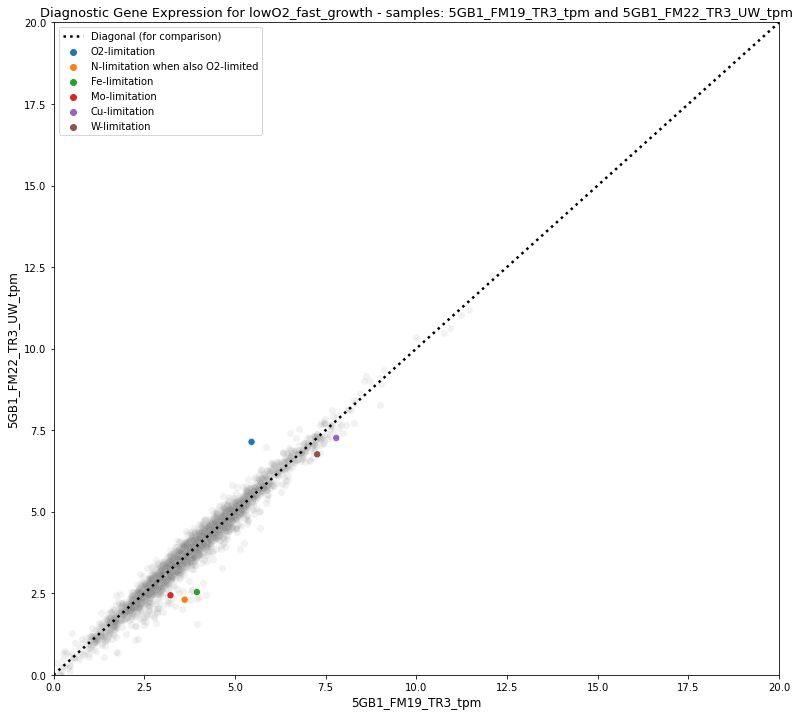

In [28]:
for i in range(0,len(df_unstable_diag_samples["Condition"])):
    plot_data = df_unstable_diag_samples.iloc[i]
    condition = plot_data["Condition"]
    s1 = str(plot_data["Sample 1"])
    s2 = str(plot_data["Sample 2"])
    filename = "plots/gene_cloud_pairwise_expression/ca_" + str(plot_data["Summary_Name"])
    
    cloud_analysis_scatter(s1, s2, condition, filename)

In [382]:
df_raw_tpm.T[s1_name]

locus_tag
EQU24_RS00005      52.395498
EQU24_RS00010      65.012759
EQU24_RS00015      33.970709
EQU24_RS00020      73.457941
EQU24_RS00025      38.467325
                    ...     
EQU24_RS22135      87.991196
EQU24_RS22140     432.863917
EQU24_RS22145     435.681411
EQU24_RS22150    1159.122423
EQU24_RS22155    1197.548565
Name: 5GB1_FM20_TR3_tpm, Length: 4213, dtype: float64

## Check Diagnostic Conditions

In [461]:
gene_to_diagnostic

{'EQU24_RS14140': 'O2-limitation',
 'EQU24_RS17070': 'N-limitation when also O2-limited',
 'EQU24_RS20550': 'Fe-limitation',
 'EQU24_RS01660': 'Mo-limitation',
 'EQU24_RS07680': 'Cu-limitation',
 'EQU24_RS01475': 'W-limitation'}